#SARIMA model

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.9 MB/s eta 0:00:00


In [2]:
#libraries
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#suppress warngings
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

##Data preprocessing

Import datasets

In [3]:
#import financial time series
ticker = "^GSPC"
start_date = "2000-01-01"
end_date = "2025-01-08"

sp500_data = yf.download(ticker, start = start_date, end = end_date, interval="1d")
sp500_data.index = sp500_data.index.tz_localize(None)
sp500_data.columns = sp500_data.columns.droplevel(1) #delete second index

#save to google drive
drive.mount("/content/gdrive")
file_path = '/content/gdrive/MyDrive/università/Machine_learning/Project_code/Datasets/sp500_data.csv'
sp500_data.to_csv(file_path, index=True)


ticker = "EURUSD=X"
start_date = "2000-01-01"
end_date = "2025-01-08"

eur_usd_data = yf.download(ticker, start = start_date, end = end_date, interval="1d")
eur_usd_data.index = eur_usd_data.index.tz_localize(None)
eur_usd_data.columns = eur_usd_data.columns.droplevel(1)


file_path = '/content/gdrive/MyDrive/università/Machine_learning/Project_code/Datasets/eur_usd_data.csv'
eur_usd_data.to_csv(file_path, index=True)


#dataset dictionary
datasets = {"sp500": sp500_data, "eur_usd": eur_usd_data}

[*********************100%***********************]  1 of 1 completed


Mounted at /content/gdrive


[*********************100%***********************]  1 of 1 completed


Close price

ADF Statistic sp500: 2.74531003055339
P-value sp500: 1.0
Normal test Statistic sp500: 1050.390
P-value sp500: 0.000


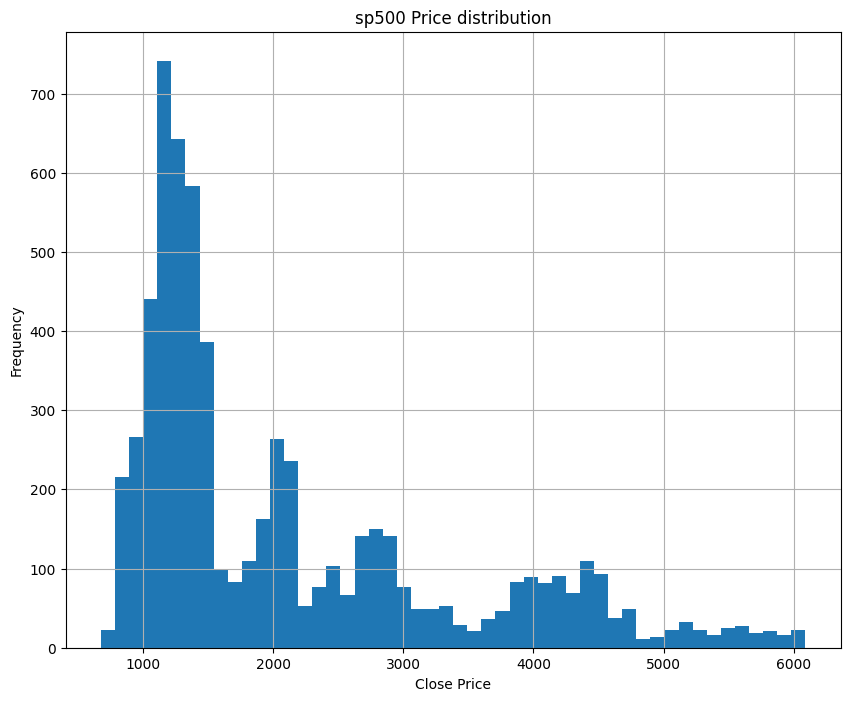

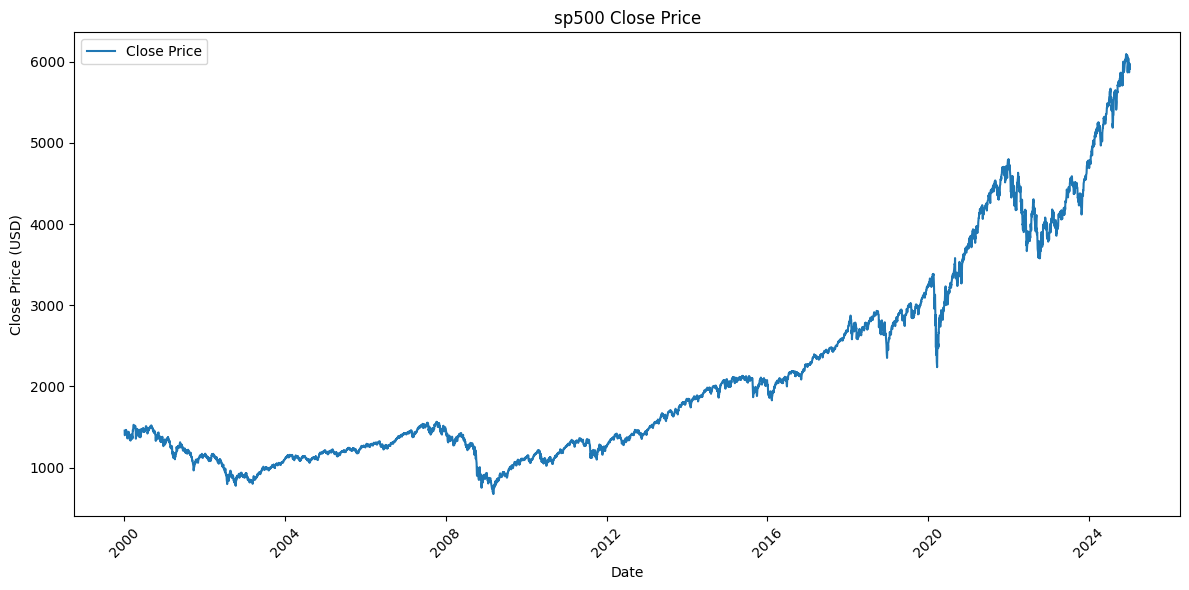

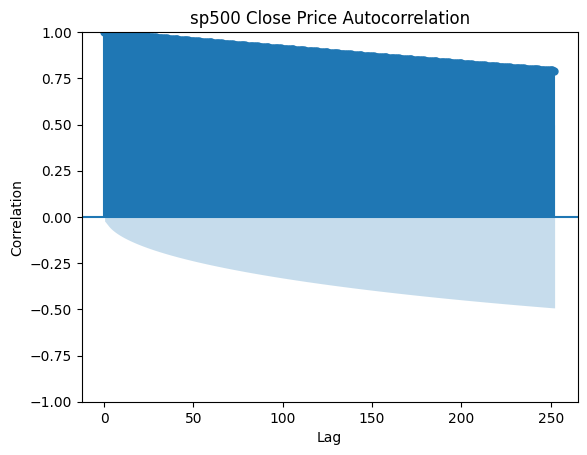

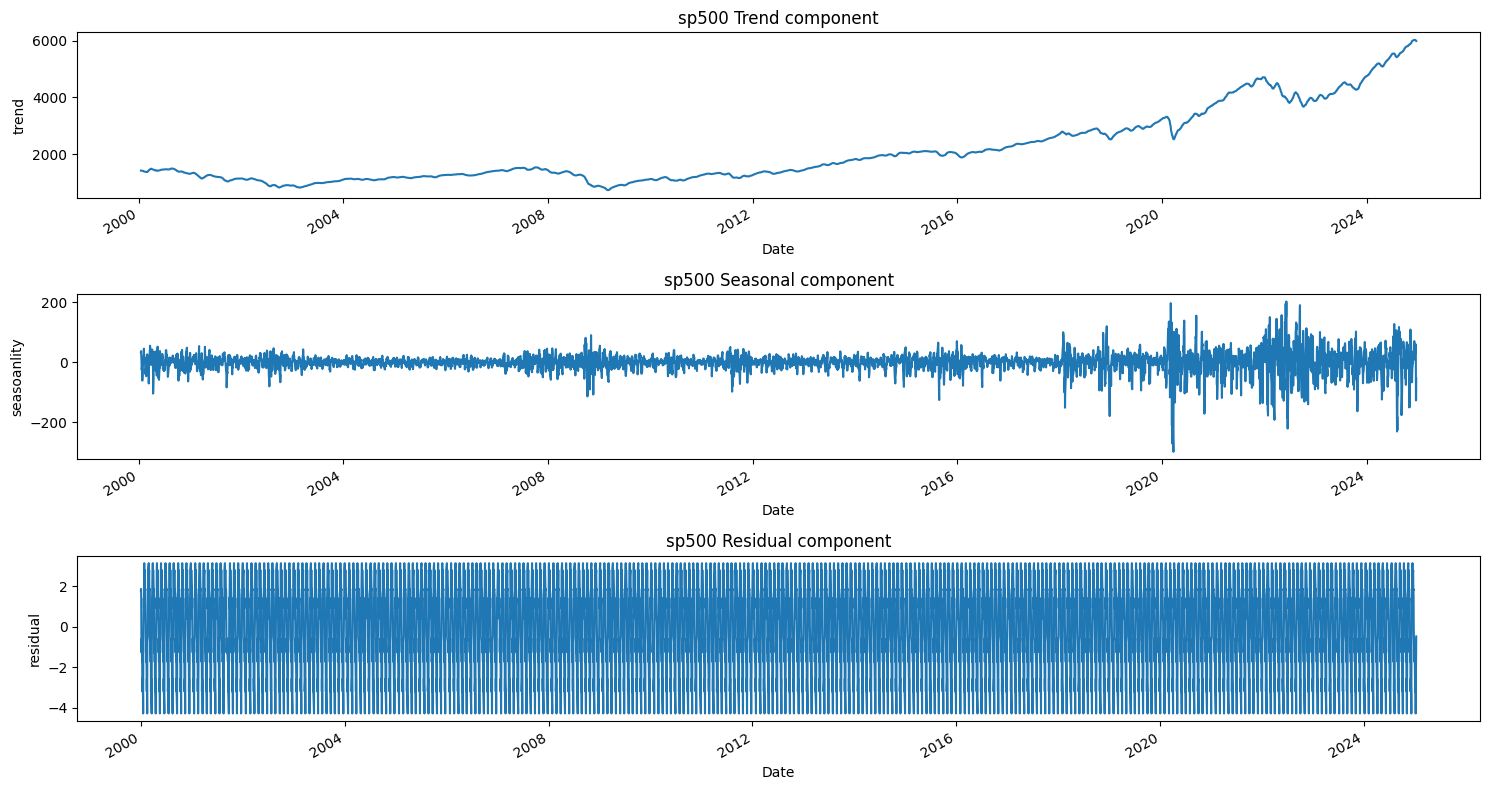

ADF Statistic eur_usd: -1.7647898171751373
P-value eur_usd: 0.3980773018282708
Normal test Statistic eur_usd: 281.071
P-value eur_usd: 0.000


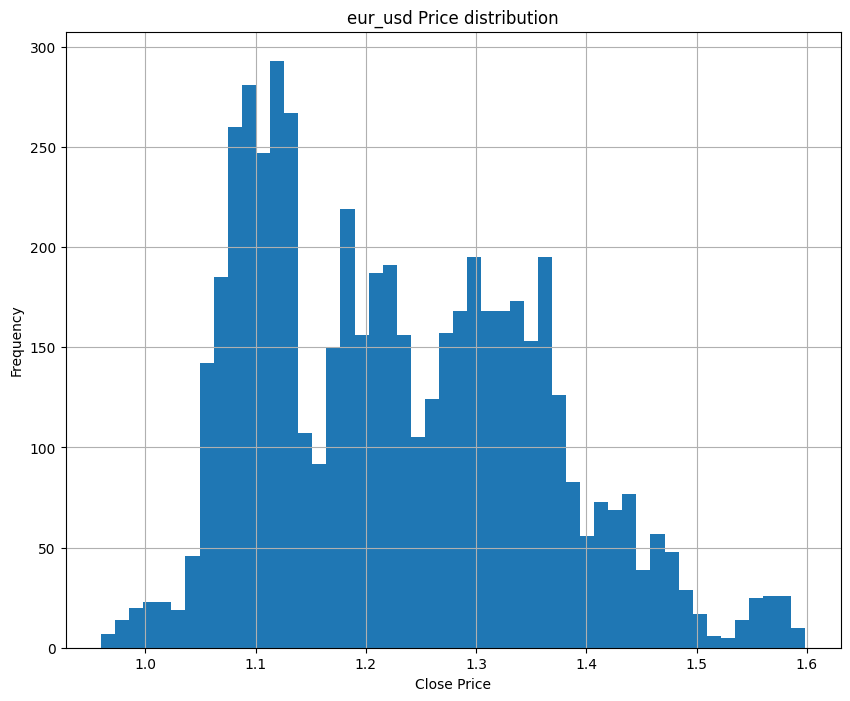

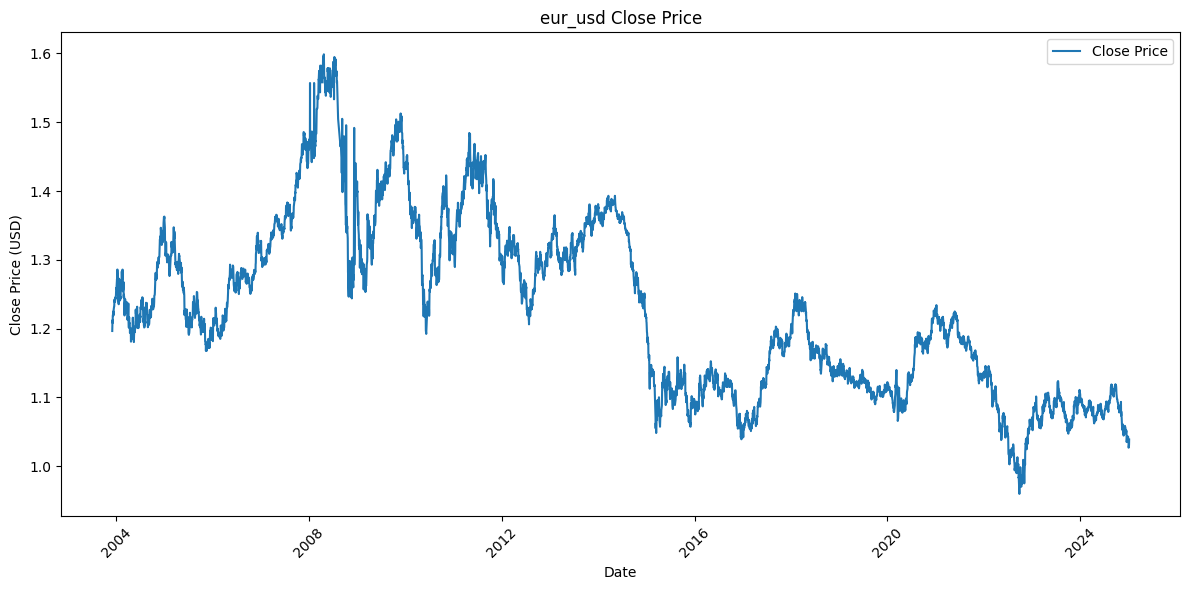

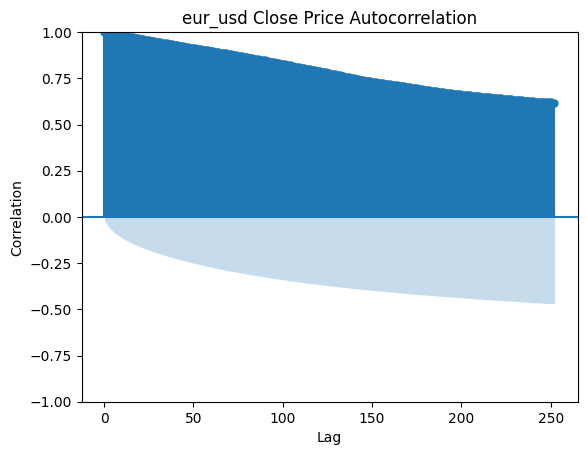

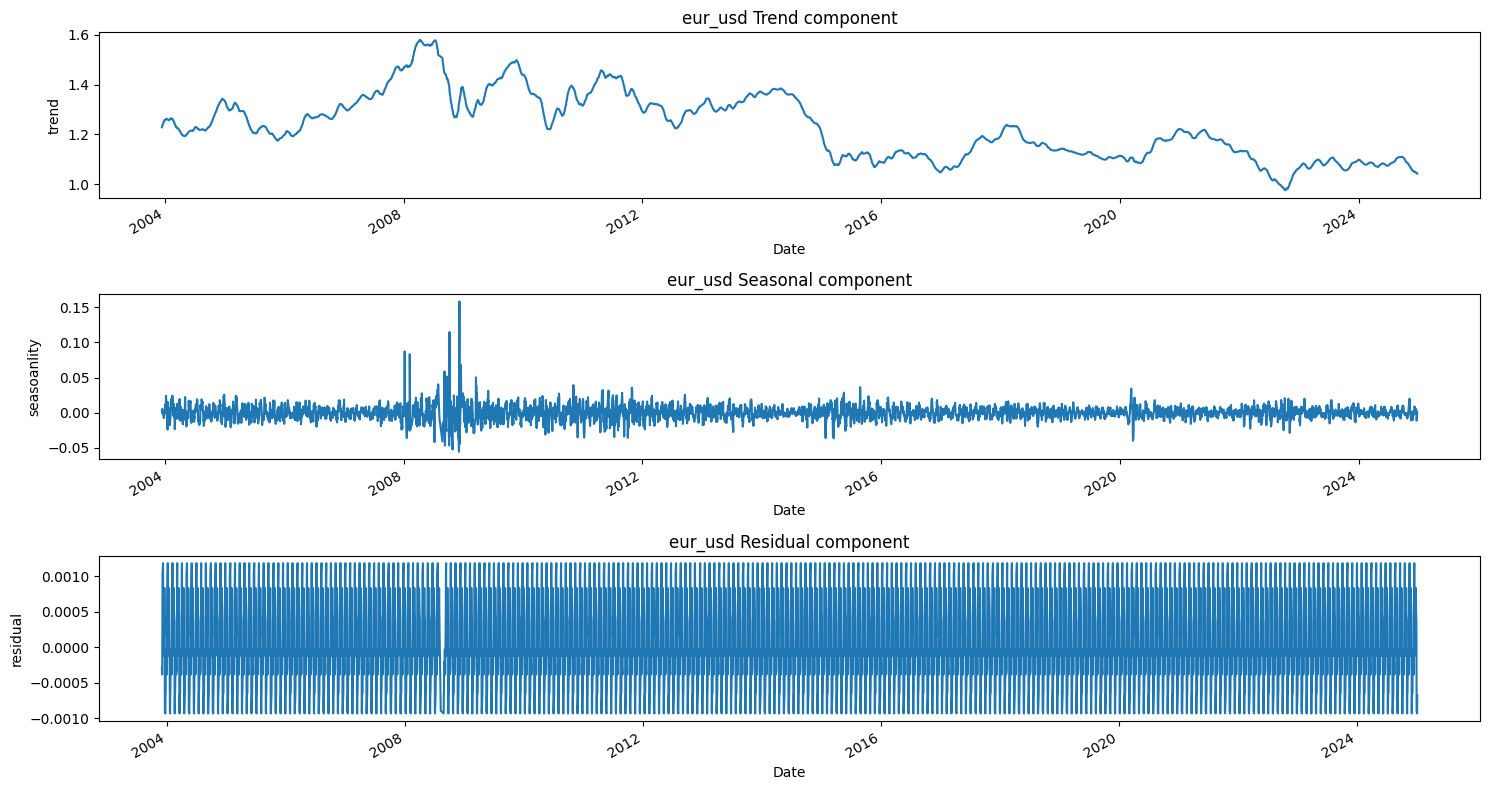

In [4]:
for name, dataset in datasets.items():

    #test stationarity with the Augmented Dickey-Fuller (ADF) test
    result = adfuller(dataset['Close'])
    print(f"ADF Statistic {name}: {result[0]}")
    print(f"P-value {name}: {result[1]}") # If the p-value is less than 0.05, the series is likely stationary


    #test normality with Normality test
    stat, p = normaltest(dataset['Close'])
    print(f"Normal test Statistic {name}: {stat:.3f}")
    print(f"P-value {name}: {p:.3f}") # If the p-value is more than 0.05, the series is normally distributed


    #visualise
    dataset['Close'].hist(bins=50, figsize=(10, 8))
    plt.title(f'{name} Price distribution')
    plt.xlabel('Close Price')
    plt.ylabel('Frequency')
    plt.show()


    plt.figure(figsize=(12, 6))
    sns.lineplot(data=dataset['Close'])
    plt.title(f'{name} Close Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend( labels=["Close Price"])
    plt.show()


    #plot autocorrelation
    plot_acf(dataset['Close'], lags=252)
    plt.title(f'{name} Close Price Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.show()


    #decompose time series
    res = seasonal_decompose(dataset['Close'], model = "additive",period = 21)
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
    res.trend.plot(ax=ax1,ylabel = "trend")
    ax1.set_title(f"{name} Trend component")
    res.resid.plot(ax=ax2,ylabel = "seasoanlity")
    ax2.set_title(f"{name} Seasonal component")
    res.seasonal.plot(ax=ax3,ylabel = "residual")
    ax3.set_title(f"{name} Residual component")

    plt.tight_layout() #adjust layout to avoid plot overlapping
    plt.show()

Log returns

ADF Statistic sp500: -19.079670761190673
P-value sp500: 0.0
Normal test Statistic sp500: 1050.390
P-value sp500: 0.000


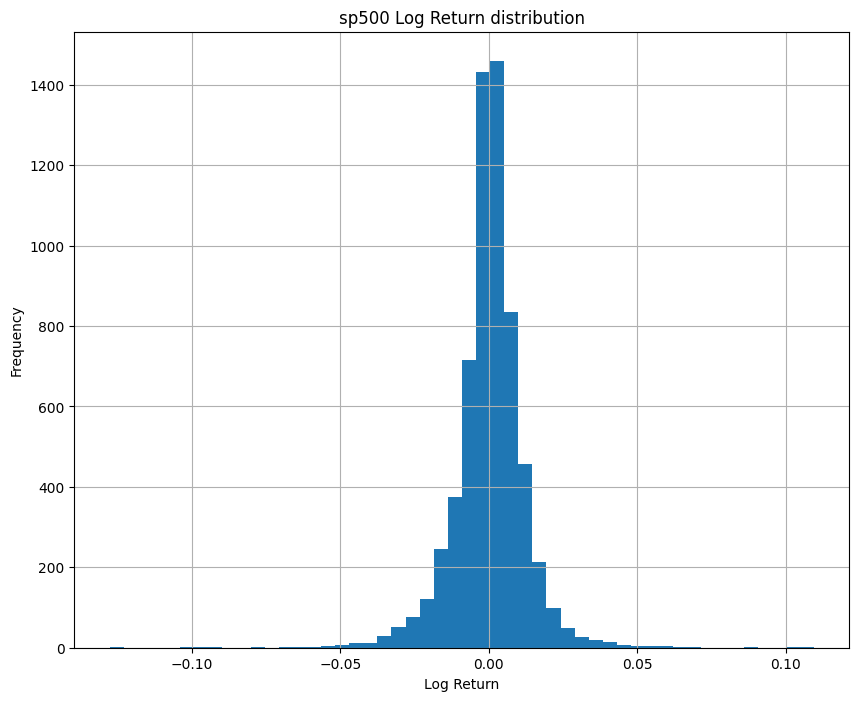

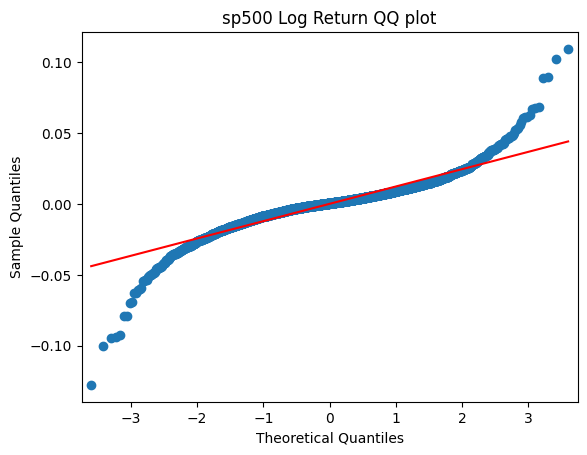

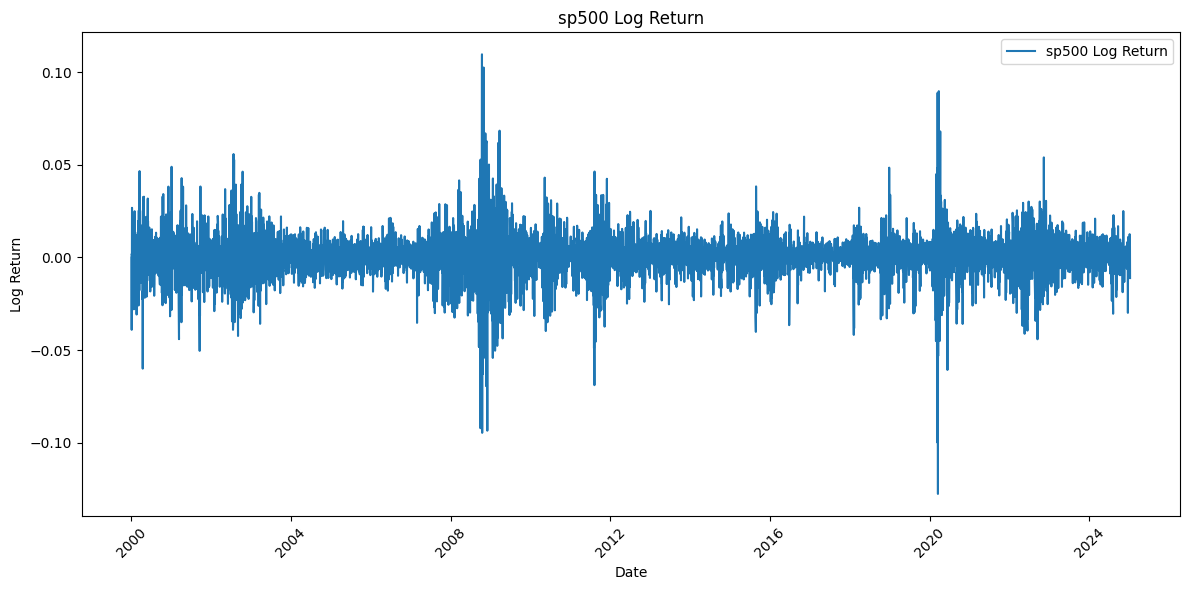

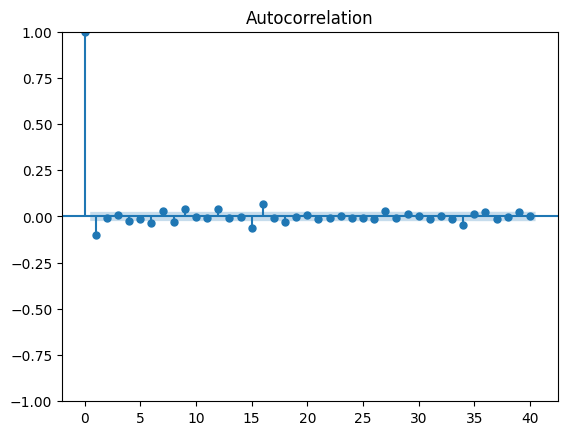

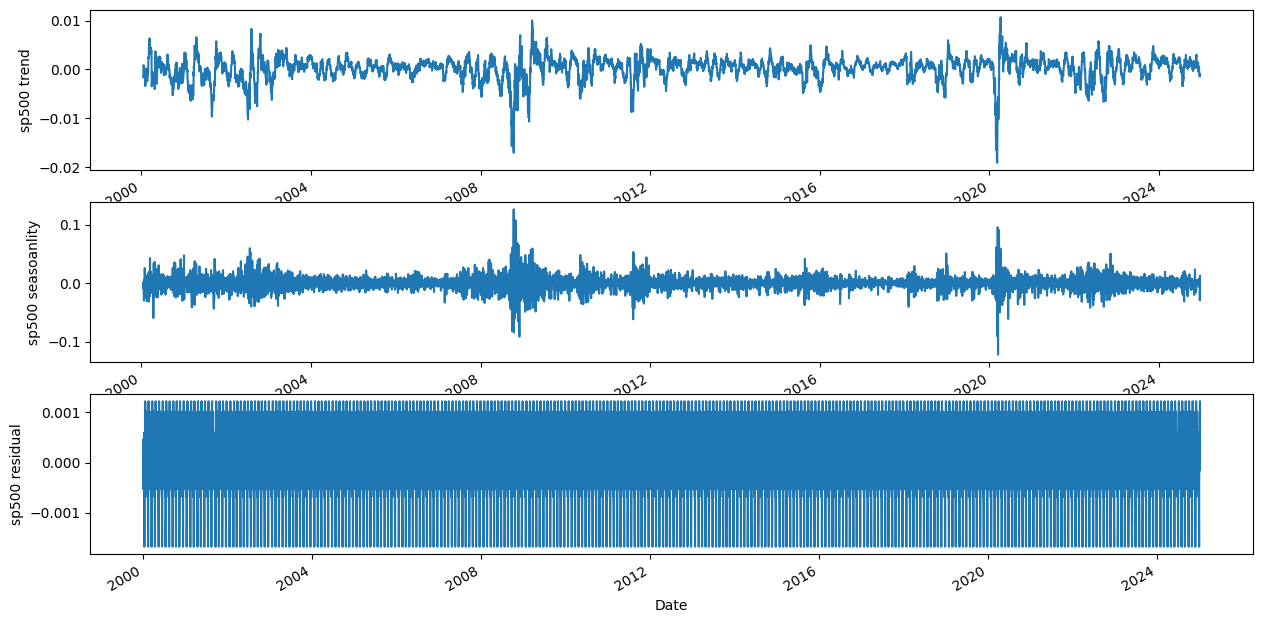

ADF Statistic eur_usd: -13.523087772400189
P-value eur_usd: 2.711056919187314e-25
Normal test Statistic eur_usd: 281.071
P-value eur_usd: 0.000


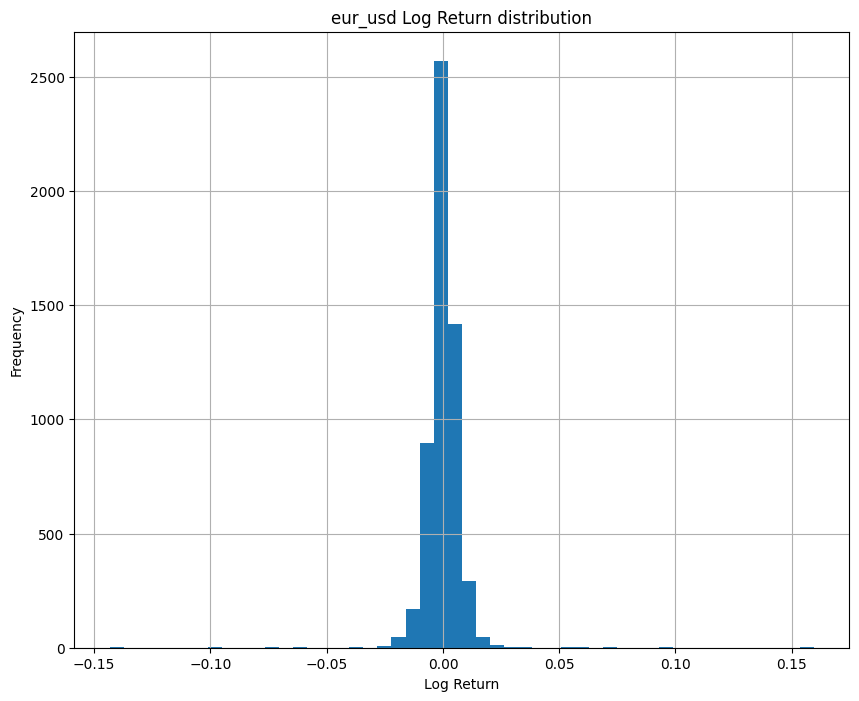

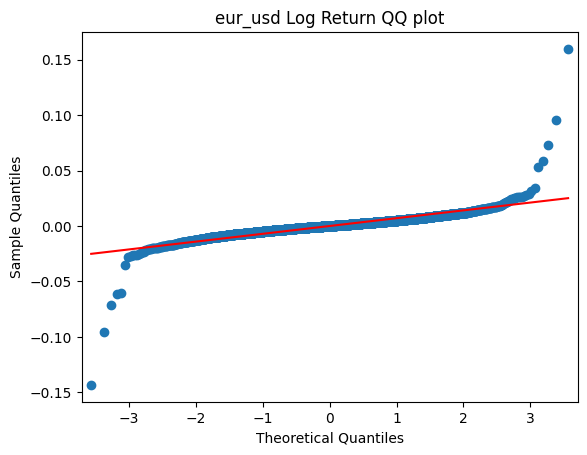

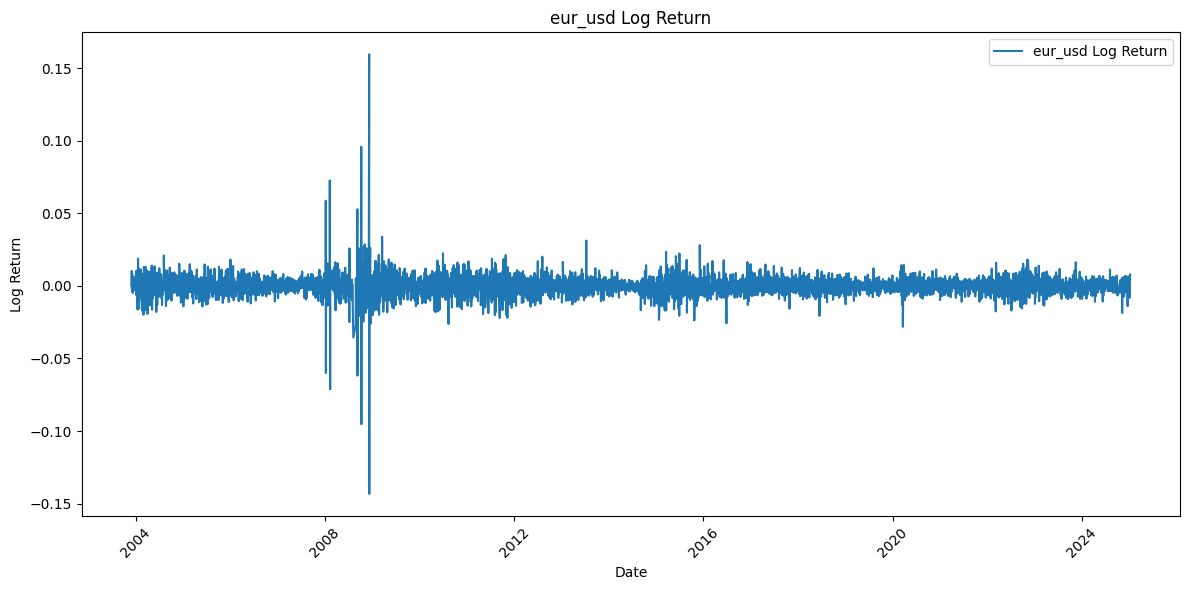

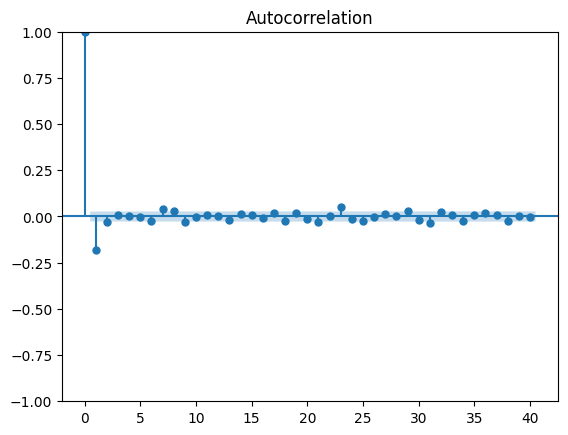

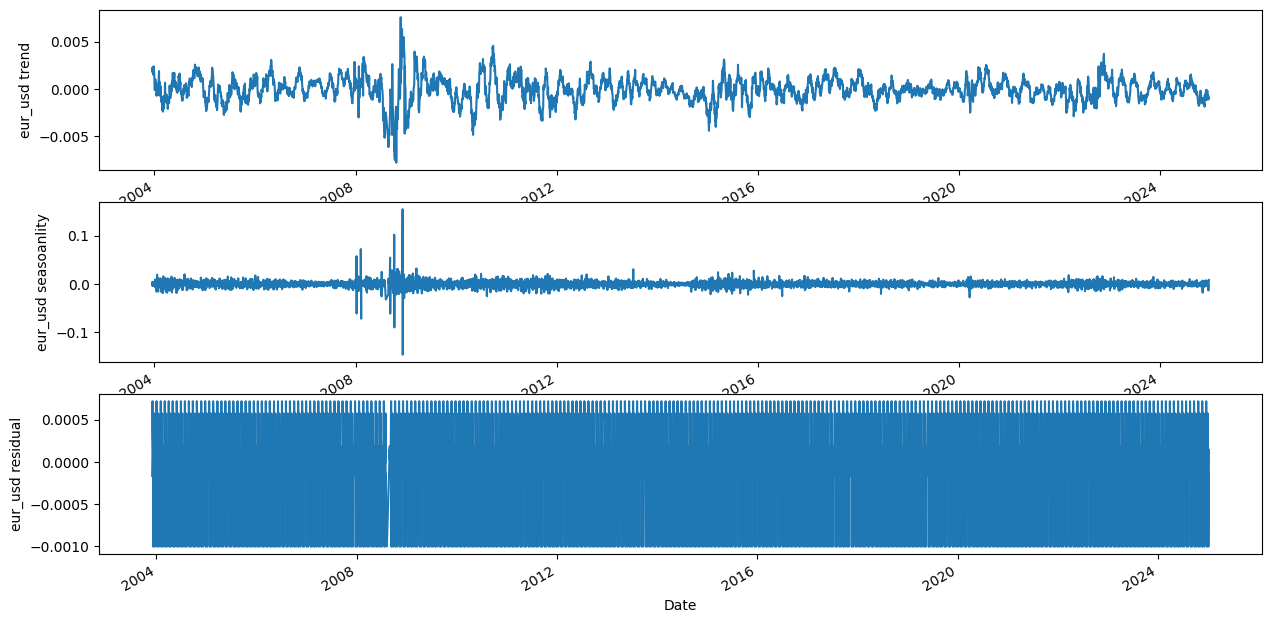

In [5]:
for name, dataset in datasets.items():

    #compute log returns
    dataset['Log Return'] = np.log(dataset['Close'] / dataset['Close'].shift(1))
    dataset.fillna(0, inplace=True)


    #test stationarity with the Augmented Dickey-Fuller (ADF) test
    result = adfuller(dataset['Log Return'])
    print(f"ADF Statistic {name}: {result[0]}")
    print(f"P-value {name}: {result[1]}") # If the p-value is less than 0.05, the series is likely stationary


    #test normality with Normality test
    stat, p = normaltest(dataset['Close'])
    print(f"Normal test Statistic {name}: {stat:.3f}")
    print(f"P-value {name}: {p:.3f}") # If the p-value is more than 0.05, the series is normally distributed


    dataset['Log Return'].hist(bins=50, figsize=(10, 8))
    plt.title(f'{name} Log Return distribution')
    plt.xlabel('Log Return')
    plt.ylabel('Frequency')
    plt.show()

    sm.qqplot(dataset['Log Return'], line='s')
    plt.title(f'{name} Log Return QQ plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.show()


    #visualise
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=dataset.index, y=dataset['Log Return'], label=f"{name} Log Return")
    plt.title(f'{name} Log Return')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.show()


    # Plot the ACF
    plot_acf(dataset['Log Return'], lags=40)  # You can adjust the number of lags
    plt.show()


    #decompose time series
    res = seasonal_decompose(dataset['Log Return'], model = "additive",period = 21)
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
    res.trend.plot(ax=ax1,ylabel = f"{name} trend")
    res.resid.plot(ax=ax2,ylabel = f"{name} seasoanlity")
    res.seasonal.plot(ax=ax3,ylabel = f"{name} residual")
    plt.show()

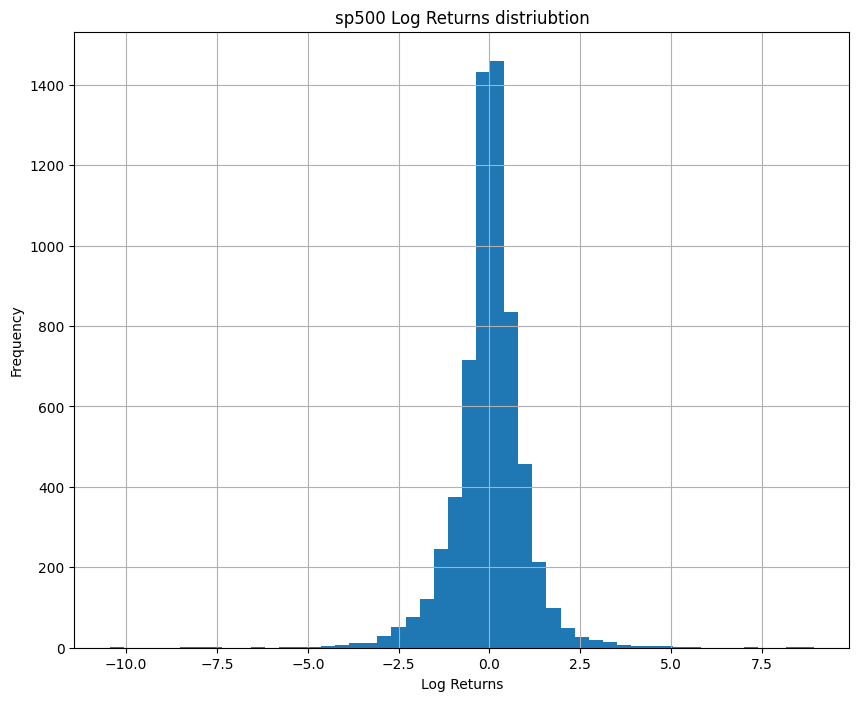

Normal test Statistic sp500: 1274.798
P-value sp500: 0.000


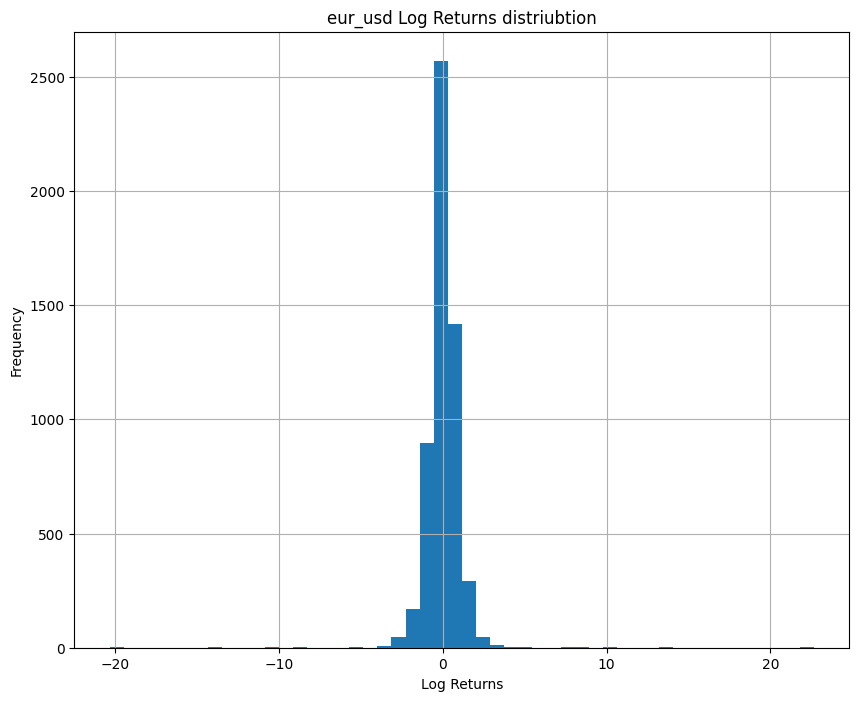

Normal test Statistic eur_usd: 2396.954
P-value eur_usd: 0.000


In [6]:
for name, dataset in datasets.items():
    # Normalize by dividing by standard deviation
    normalized_returns = (dataset['Log Return'] -dataset['Log Return'].mean()) / dataset['Log Return'].std()
    normalized_returns.hist(bins=50, figsize=(10, 8))
    plt.title(f'{name} Log Returns distriubtion')
    plt.xlabel('Log Returns')
    plt.ylabel('Frequency')
    plt.show()

    #test normality
    stat, p = normaltest(normalized_returns)
    print(f"Normal test Statistic {name}: {stat:.3f}")
    print(f"P-value {name}: {p:.3f}")

Check seasonality for other periods

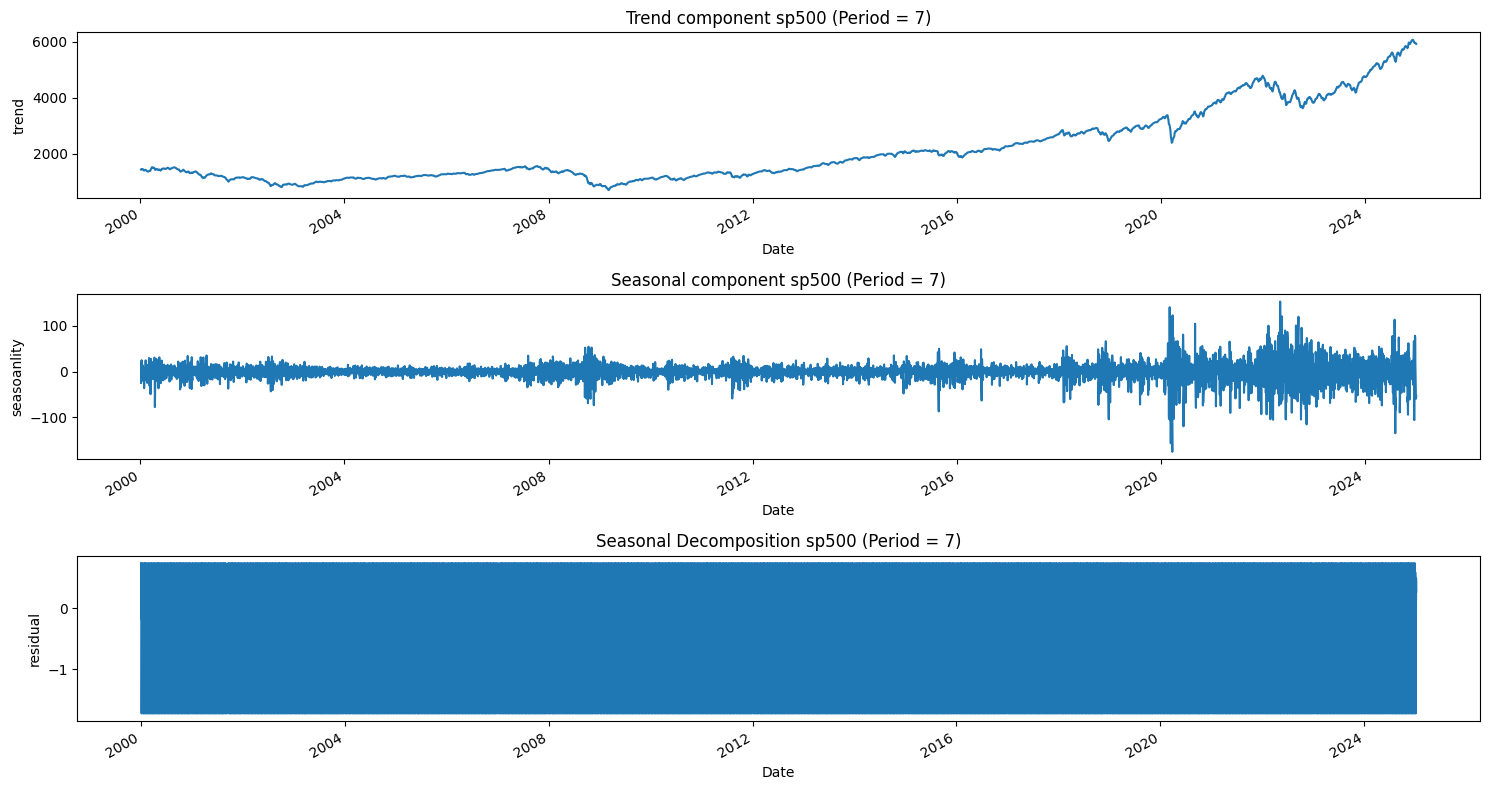

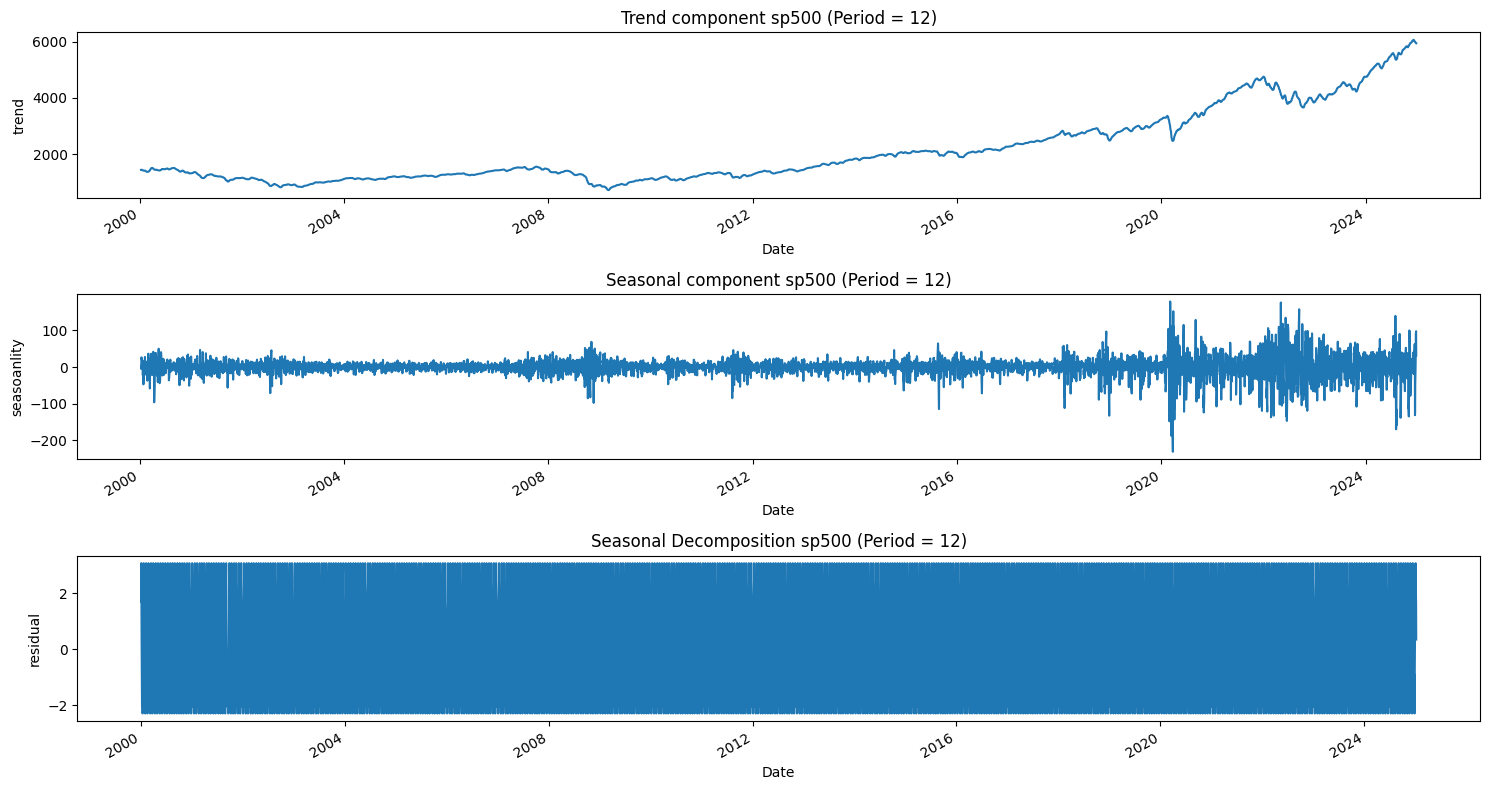

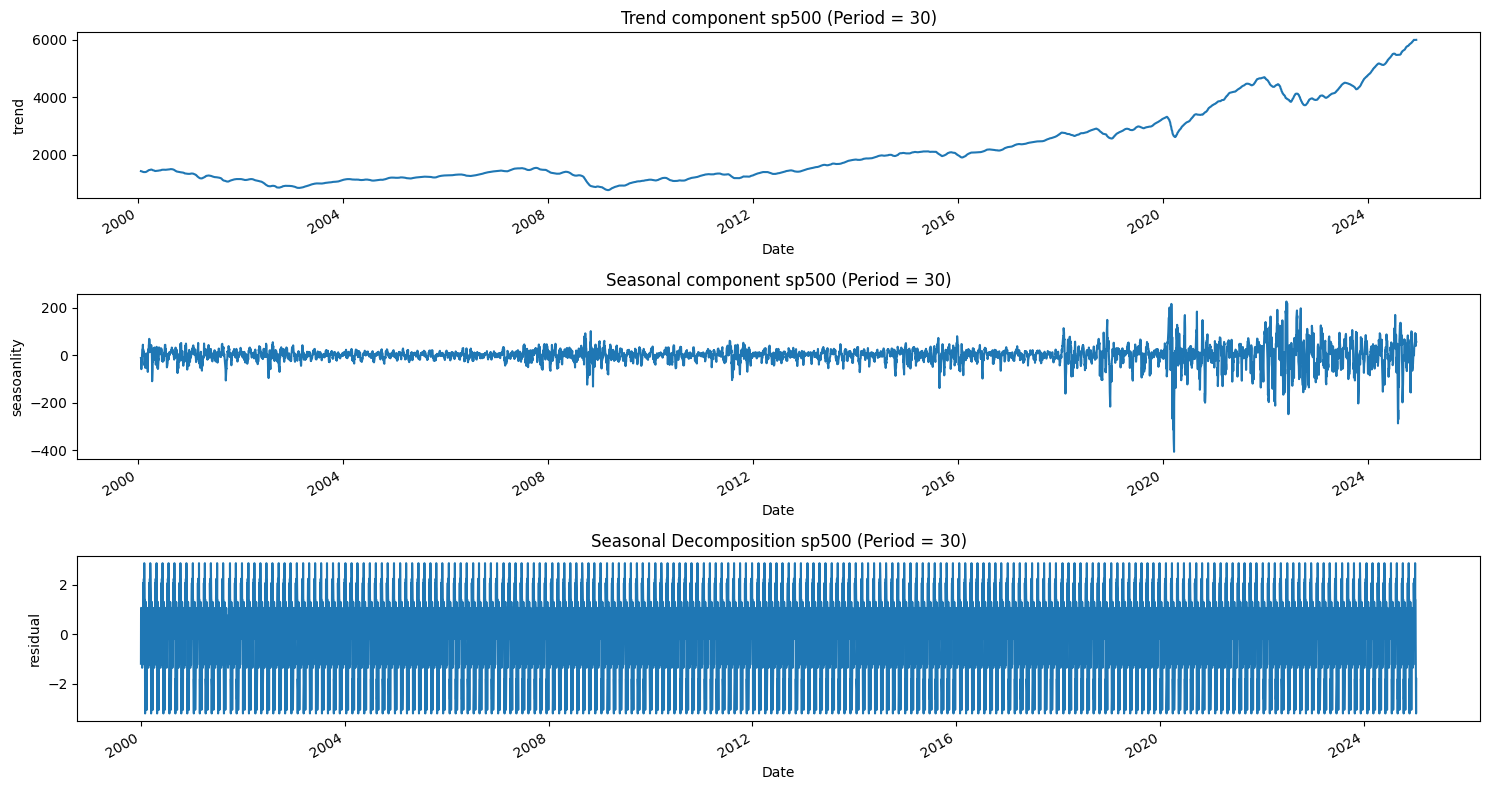

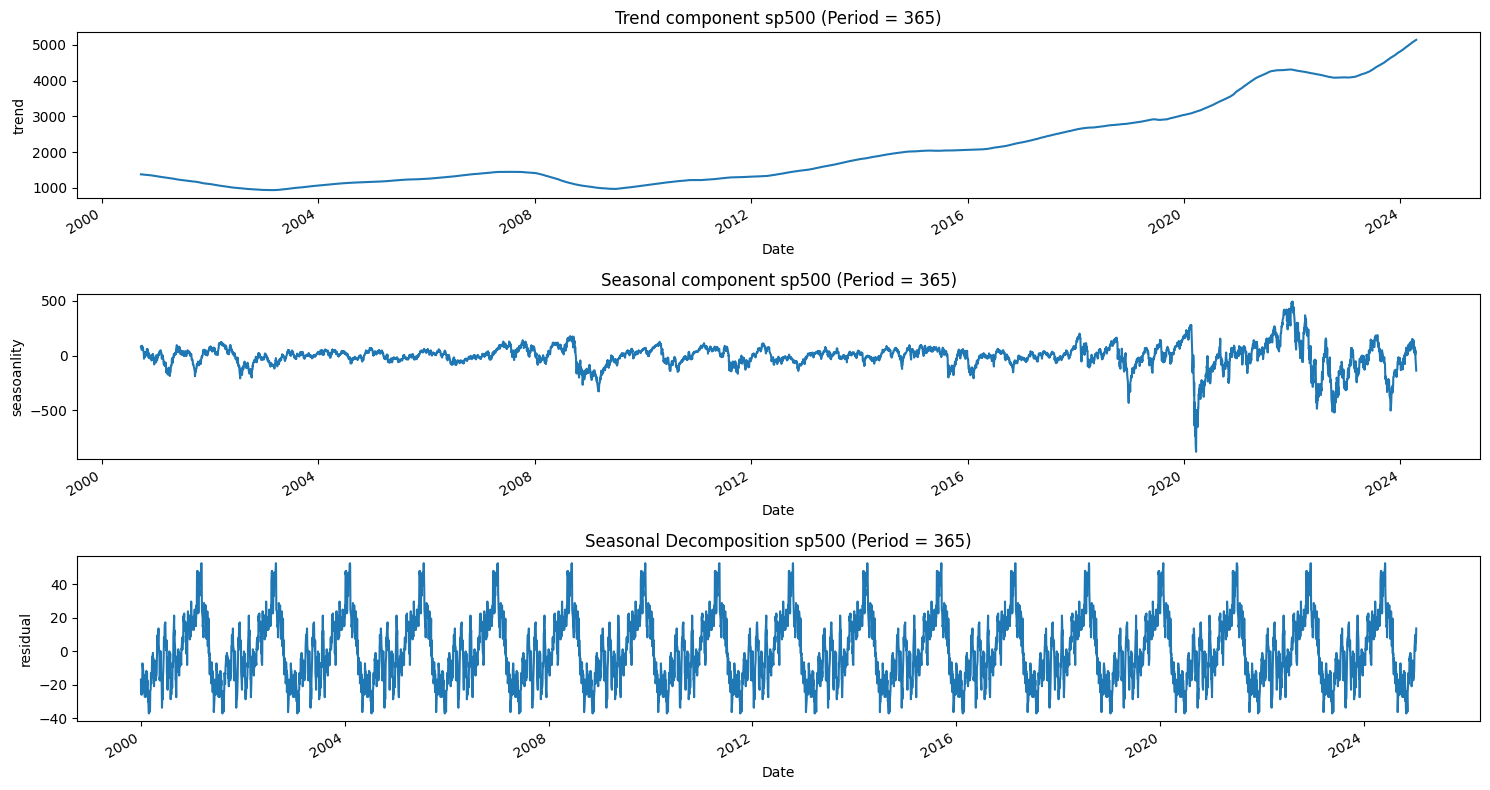

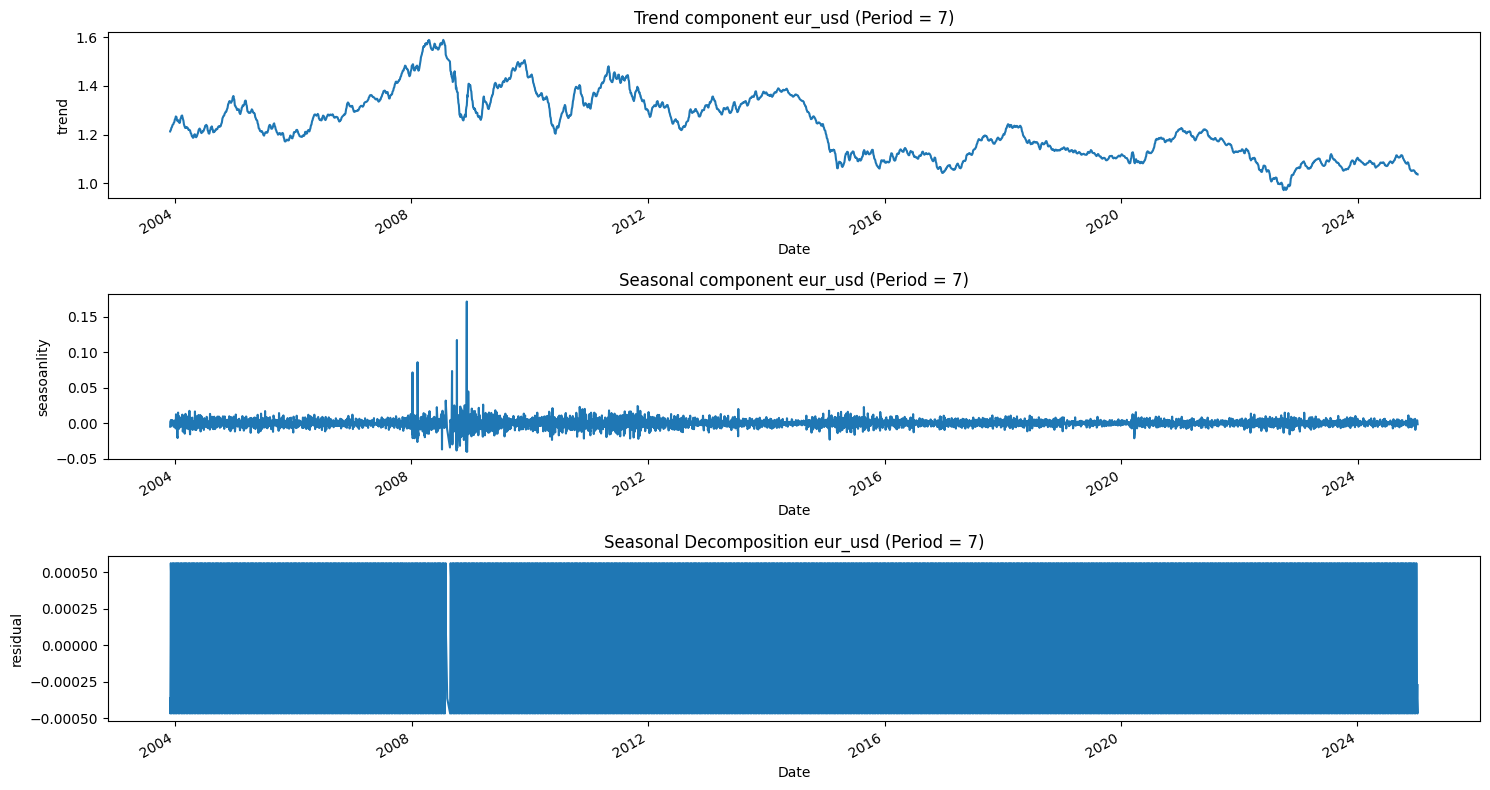

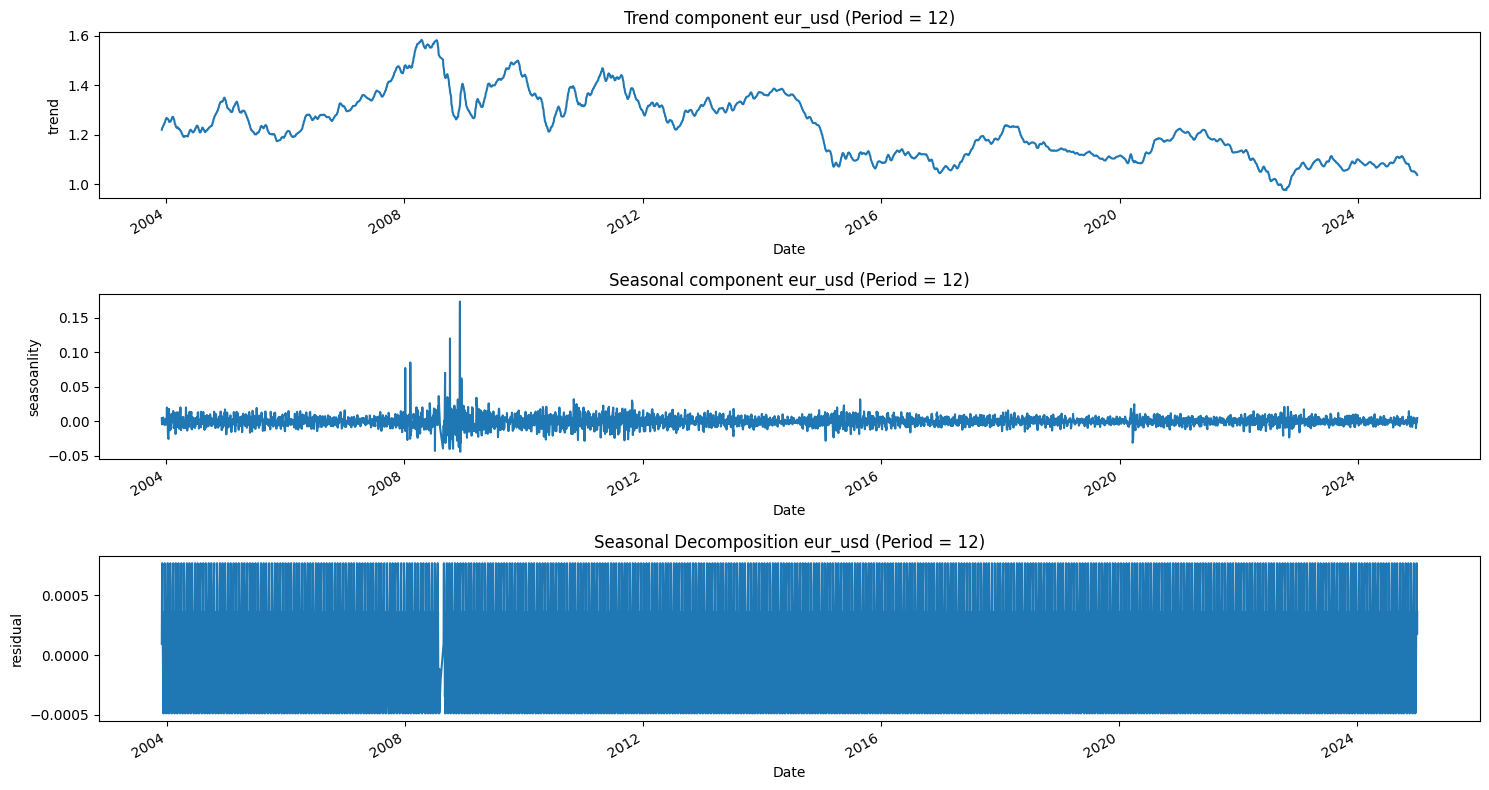

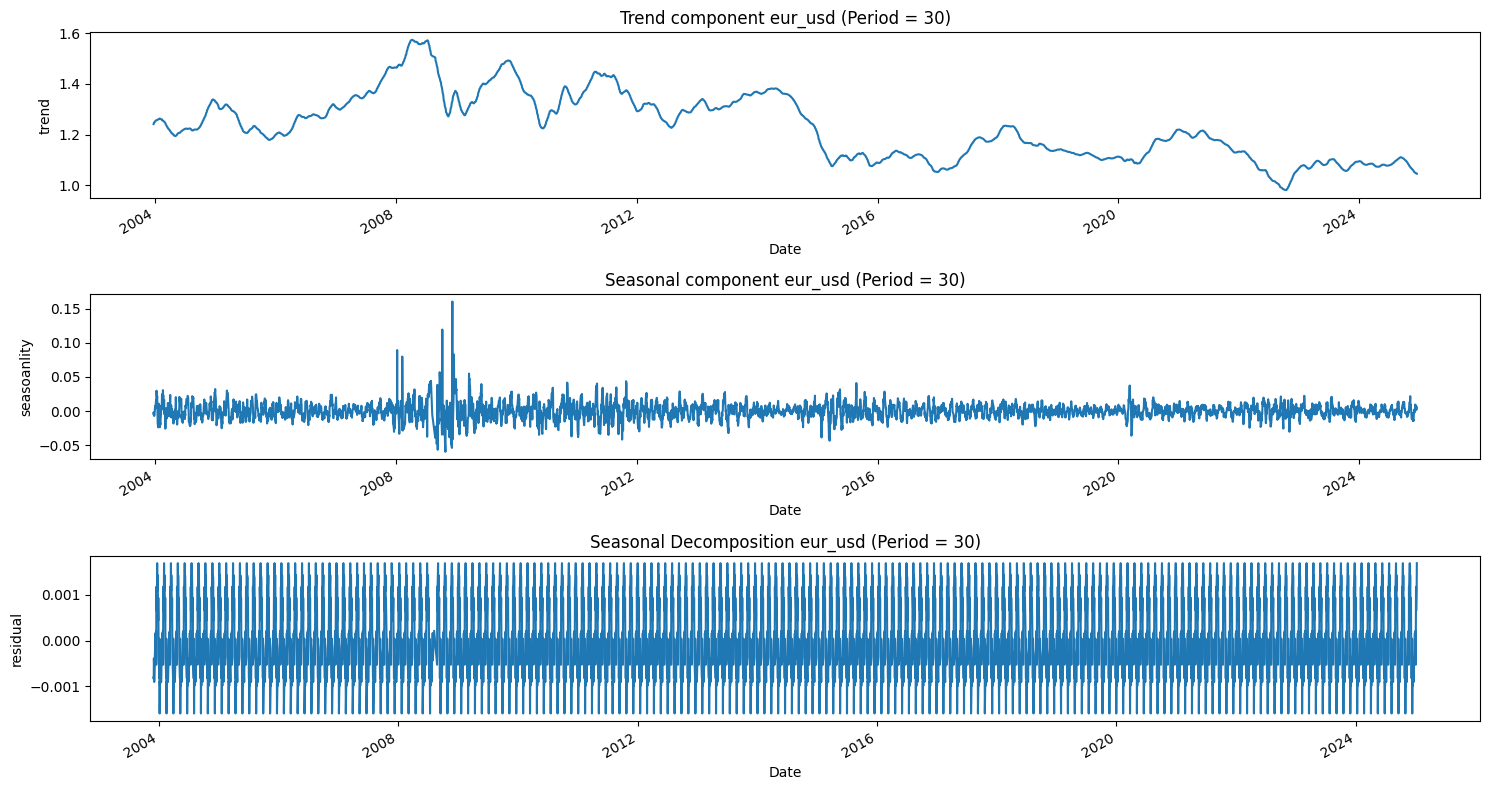

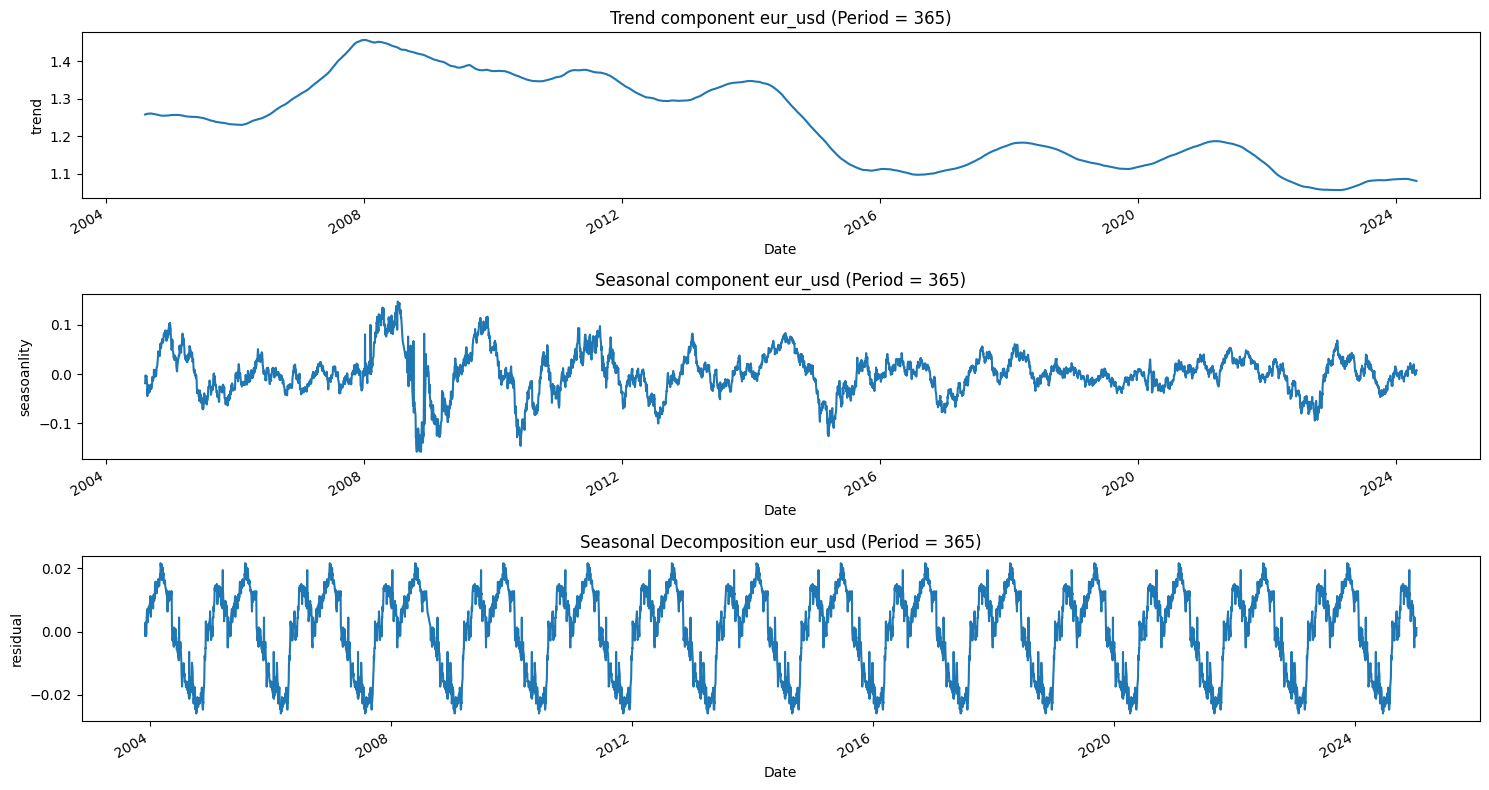

In [7]:
for name, dataset in datasets.items():

    periods = [7, 12, 30, 365]  # Example: weekly, monthly, 30-day, yearly
    for period in periods:
        res = seasonal_decompose(dataset['Close'], model = "additive",period = period)
        fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
        res.trend.plot(ax=ax1,ylabel = "trend")
        ax1.set_title(f"Trend component {name} (Period = {period})")
        res.resid.plot(ax=ax2,ylabel = "seasoanlity")
        ax2.set_title(f"Seasonal component {name} (Period = {period})")
        res.seasonal.plot(ax=ax3,ylabel = "residual")
        ax3.set_title(f"Residual component {name} (Period = {period})")
        plt.title(f"Seasonal Decomposition {name} (Period = {period})")
        plt.tight_layout() #adjust layout to avoid plot overlapping
        plt.show()

Train Val Test split

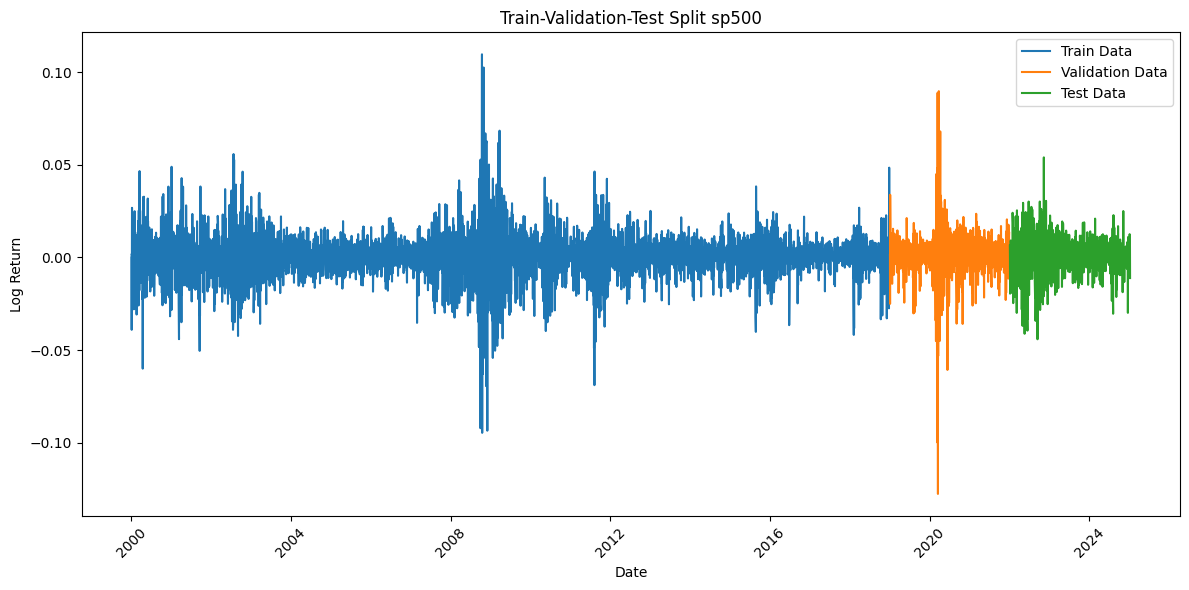

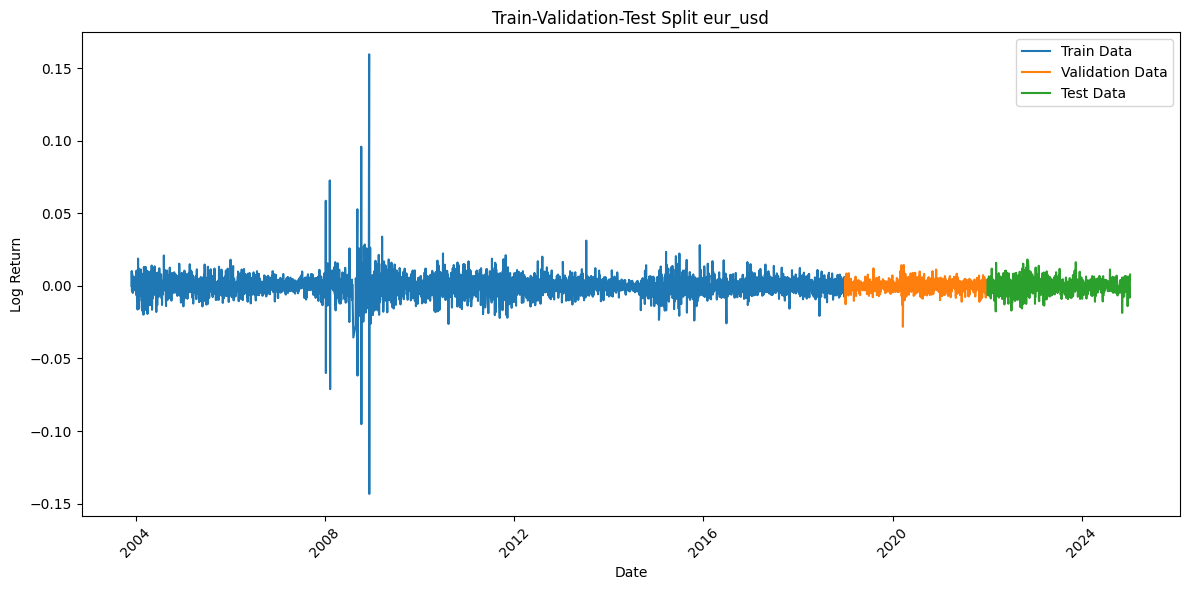

In [8]:
#train / validation / test split
train_data = {}
val_data = {}
test_data = {}
train_val_data = {}

for name, dataset in datasets.items():

    train_data[name] = dataset['Log Return'].loc[: '2018']
    val_data[name] = dataset['Log Return'].loc['2019': '2021']
    test_data[name] = dataset['Log Return'].loc['2022':]
    train_val_data[name] = dataset['Log Return'].loc[: '2021']


    #visualize
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=train_data[name].index, y=train_data[name].values, label="Train Data")
    sns.lineplot(x=val_data[name].index, y=val_data[name].values, label="Validation Data")
    sns.lineplot(x=test_data[name].index, y=test_data[name].values, label="Test Data")
    plt.title(f'Train-Validation-Test Split {name}')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()

##Hyperparameters tuning using Bayesian Optimization

In [ ]:
!pip install arm-mango

In [ ]:
#libraries
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mango import scheduler #to perform Bayesian optimization
from mango.tuner import Tuner
from google.colab import drive
from joblib import Parallel, delayed, dump, load
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
#parallel bayesian optimization
class OptimizationMangoParallel:
  def __init__(self, njobs: int, configuration_params: dict, train_data, val_data):
      self.conf_dict = configuration_params  # parameters to configure the Tuner
      self.njobs = njobs
      self.train_data = train_data
      self.val_data = val_data
      self.space = dict(p= range(0, 5), # Definition of the search space of the algorithm
                        d=[0, 1],
                        q =range(0, 5),  #use of range to ensure integers
                        # trend = ['n', 'c'],
                        trend = ['n'],
                        Q = range(0, 5),
                        P = range(0, 5),
                        # Q = [1],
                        # P = [1],
                        D = [0,1],
                        periods = [30]
                        )


  #This is the loss function that mango optimizes
  def arima_objetive_function(self, **params):

    try:
        p,d,q = params['p'],params['d'], params['q']
        trend = params['trend']
        Q, P, D, periods = params['Q'], params['P'], params['D'], params['periods']
        print(f"training model: SARIMA ({p,d,q}), ({P,D,Q}), {trend}")
        model = ARIMA(self.train_data, order=(p,d,q), trend = trend,  seasonal_order = (P, D, Q, periods)).fit(method='innovations_mle', low_memory=True, cov_type='none') #train ARIMA model with the subset of hyperparameters
        # print("model has finished to train")
        predictions = model.forecast(steps=len(self.val_data)) #get forecast
        rmse = np.sqrt(mean_squared_error(self.val_data, predictions))  #compute rmse
        return mse
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return 1e5  # Penalize error cases


  def _objective2(self, params_batch): #to perform bayesian optimization in parallel
      global parameters
      results_batch = Parallel(self.njobs, backend="threading")(delayed(self.arima_objetive_function)(**params) for params in params_batch)
      rmse = [result for result in results_batch]
      return rmse


  def mango_optimization(self):
      tuner = Tuner(self.space, self._objective2, self.conf_dict)
      optimisation_results = tuner.minimize()
      return optimisation_results['best_params'], optimisation_results['best_objective']


 # Parallel Bayesian optimization
config_params = {'num_iteration': 40, 'initial_random': 10}
start_time = time.time()
optim = OptimizationMangoParallel(njobs=4, configuration_params=config_params, train_data=train_data['eur/usd'], val_data=val_data['eur/usd'])
best_parameters, best_objective = optim.mango_optimization()
print(f'The optimisation in parallel takes {(time.time() - start_time) / 60.} minutes.')

# Inspect the results
print('best parameters:', best_parameters)
print('best accuracy:', best_objective)

Optimize error on train val set

In [ ]:
#parallel bayesian optimization
class OptimizationMangoParallel:
  def __init__(self, njobs: int, configuration_params: dict, train_val_data):
      self.conf_dict = configuration_params  # parameters to configure the Tuner
      self.njobs = njobs
      self.train_val_data = train_val_data
      self.space = dict(p= range(0, 5), # Definition of the search space of the algorithm
                        d=[0, 1],
                        q =range(0, 5),  #use of range to ensure integers
                        # trend = ['n', 'c'],
                        trend = ['n'],
                        Q = range(0, 5),
                        P = range(0, 5),
                        # Q = [1],
                        # P = [1],
                        D = [1],
                        periods = range(2, 30)
                        )


  #This is the loss function that mango optimizes
  def arima_objetive_function(self, **params):

    try:
        p,d,q = params['p'],params['d'], params['q']
        trend = params['trend']
        Q, P, D, periods = params['Q'], params['P'], params['D'], params['periods']
        print(f"training model: SARIMA ({p,d,q}), ({P,D,Q, periods}), {trend}")
        model = ARIMA(self.train_val_data, order=(p,d,q), trend = trend,  seasonal_order = (P, D, Q, periods)).fit(method='innovations_mle', low_memory=True, cov_type='none') #train ARIMA model with the subset of hyperparameters
        # rmse = np.sqrt(mean_squared_error(self.train_val_data, model.fittedvalues))  #compute rmse

        r2 = r2_score(self.train_val_data, model.fittedvalues)
        return r2
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return 1e5  # Penalize error cases


  def _objective2(self, params_batch): #to perform bayesian optimization in parallel
      global parameters
      results_batch = Parallel(self.njobs, backend="threading")(delayed(self.arima_objetive_function)(**params) for params in params_batch)
      r2 = [result for result in results_batch]
      return r2


  def mango_optimization(self):
      tuner = Tuner(self.space, self._objective2, self.conf_dict)
      optimisation_results = tuner.minimize()
      return optimisation_results['best_params'], optimisation_results['best_objective']


 # Parallel Bayesian optimization
config_params = {'num_iteration': 50, 'initial_random': 15}
start_time = time.time()
optim = OptimizationMangoParallel(njobs=4, configuration_params=config_params, train_val_data=train_val_data['eur/usd'])
best_parameters, best_objective = optim.mango_optimization()
print(f'The optimisation in parallel takes {(time.time() - start_time) / 60.} minutes.')

# Inspect the results
print('best parameters:', best_parameters)
print('best accuracy:', best_objective)

training model: SARIMA ((1, 0, 4)), ((1, 1, 1, 5)), n
training model: SARIMA ((4, 0, 0)), ((2, 1, 3, 25)), n
training model: SARIMA ((4, 0, 2)), ((3, 1, 3, 29)), n
training model: SARIMA ((2, 0, 2)), ((0, 1, 0, 13)), n


##Inference

In [ ]:
#find best hyperparameters with auto arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_arima = auto_arima(train_val_data[name],
                        start_p=0, max_p=5,   # Range for AR terms
                        start_q=0, max_q=5,   # Range for MA terms
                        d=None,              # Let auto_arima find `d`
                        seasonal=True,
                        start_P=0, max_P=3,  # Seasonal AR range
                        start_Q=0, max_Q=3,  # Seasonal MA range
                        D=1,                 # Seasonal differencing
                        m=30,                # Monthly seasonality
                        stepwise=True,
                        trace=True,
                        suppress_warnings=True,
                        error_action="ignore")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[30] intercept   : AIC=-29242.063, Time=3.89 sec
 ARIMA(1,0,0)(1,1,0)[30] intercept   : AIC=-30751.084, Time=72.42 sec
 ARIMA(0,0,1)(0,1,1)[30] intercept   : AIC=inf, Time=107.19 sec
 ARIMA(0,0,0)(0,1,0)[30]             : AIC=-29244.051, Time=1.28 sec
 ARIMA(1,0,0)(0,1,0)[30] intercept   : AIC=-29409.960, Time=4.81 sec
 ARIMA(1,0,0)(2,1,0)[30] intercept   : AIC=-31404.332, Time=357.05 sec


In [9]:
#p represent the number of lagged observations used as predictors in the model.
#q epresents the number of lagged forecast errors used in the model.

#P represents the number of seasonal autoregressive (SAR) terms in the model.
#Q 2epresents the number of seasonal moving average (SMA) terms in the model.

model = {}
forecast = {}
predicted_close_price = {}
fitted_close_price = {}

for name, dataset in datasets.items():
    #train model
    if name == "sp500":
        print(f"training model on {name}")
        model[name] = ARIMA(train_val_data[name], order=(5, 1, 1), trend = 'n', seasonal_order=(1, 1, 1, 30)).fit(method='innovations_mle', low_memory=True, cov_type='none')
        forecast[name] = model[name].forecast(steps=len(test_data[name])) #predict
        forecast[name].index = test_data[name].index

    elif name == "eur_usd":
        print(f"training model on {name}")
        model[name] = ARIMA(train_val_data[name], order=(2, 0, 2), trend = 'n', seasonal_order=(0,1, 1, 5)).fit(method='innovations_mle', low_memory=True, cov_type='none')
        # model[name] = ARIMA(train_val_data[name], order=(2, 0, 2), trend = 'n', seasonal_order=(0 , 1, 1, 5)).fit(method='innovations_mle', low_memory=True, cov_type='none')
        forecast[name] = model[name].forecast(steps=len(test_data[name])) #predict
        forecast[name].index = test_data[name].index


training model on sp500
training model on eur_usd


Rolling predictions

In [ ]:
#rolling predictions
for name, dataset in datasets.items():

    if name == "sp500":
        continue #predictions already done


    history = list(train_val_data[name])
    forecasts = []
    total_steps=0
    model = ARIMA(history, order=(2, 0, 2), trend = 'n', seasonal_order=(0, 1, 1, 5)).fit(method='innovations_mle', low_memory=True, cov_type='none')

    for i in range(len(test_data[name])):
        # steps = 10 if i < len(test_data) // 10 else len(test_data) % 10
        total_steps += 1;
        forecast = model.forecast(steps=1)[0]  # Forecast 1 step ahead
        forecasts.append(forecast)

        history.append(test_data[name].iloc[i])  # Add the actual value to the history
        # sns.lineplot(data = history)
        # plt.show()
        # result = adfuller(history)
        # print(f"ADF Statistic {name}: {result[0]}")
        # print(f"P-value {name}: {result[1]}") # If the p-value is less than 0.05, the series is likely stationary

        # Re-fit the model on the updated data
        # model = ARIMA(history, order=(2, 0, 2), trend = 'n', seasonal_order=(0, 1, 1, 5), enforce_stationarity=True).fit(method='innovations_mle', low_memory=True, cov_type='none')
        model = ARIMA(history, order=(2, 0, 2), trend = 'n', seasonal_order=(0, 1, 1, 5), enforce_stationarity=True).fit()

        #verbose
        print(f"step: {total_steps}, forecast: {forecast}, actual: {test_data[name].iloc[i]}")

step: 1, forecast: -0.0005548664840896102, actual: 0.004267353279425453
step: 2, forecast: -0.000295702901317985, actual: -0.006281143232397632
step: 3, forecast: 0.0011670273364796412, actual: -0.0016487567784744634
step: 4, forecast: 8.476395464303895e-05, actual: 0.0026438305657729066
step: 5, forecast: -0.00021778532539959905, actual: -0.0014697139139755349
step: 6, forecast: 0.0001872060092182274, actual: 0.005039876404767347
step: 7, forecast: -0.0007454462366017064, actual: -0.0020756708987675625
step: 8, forecast: 0.00025450559864930193, actual: 0.003177601119399733
step: 9, forecast: -0.0010067688029752899, actual: 0.006591516828806482
step: 10, forecast: -0.0015737068164511053, actual: 0.0013509382484209274
step: 11, forecast: -0.0009898485520361622, actual: -0.004059033506041168
step: 12, forecast: 0.0003343774377229424, actual: -1.1387453022310162e-05
step: 13, forecast: 1.580418877239519e-05, actual: -0.0071176043295396296
step: 14, forecast: 0.0011471152561027117, actual:

ValueError: Length mismatch: Expected axis has 786 elements, new values have 6291 elements

Test predicion

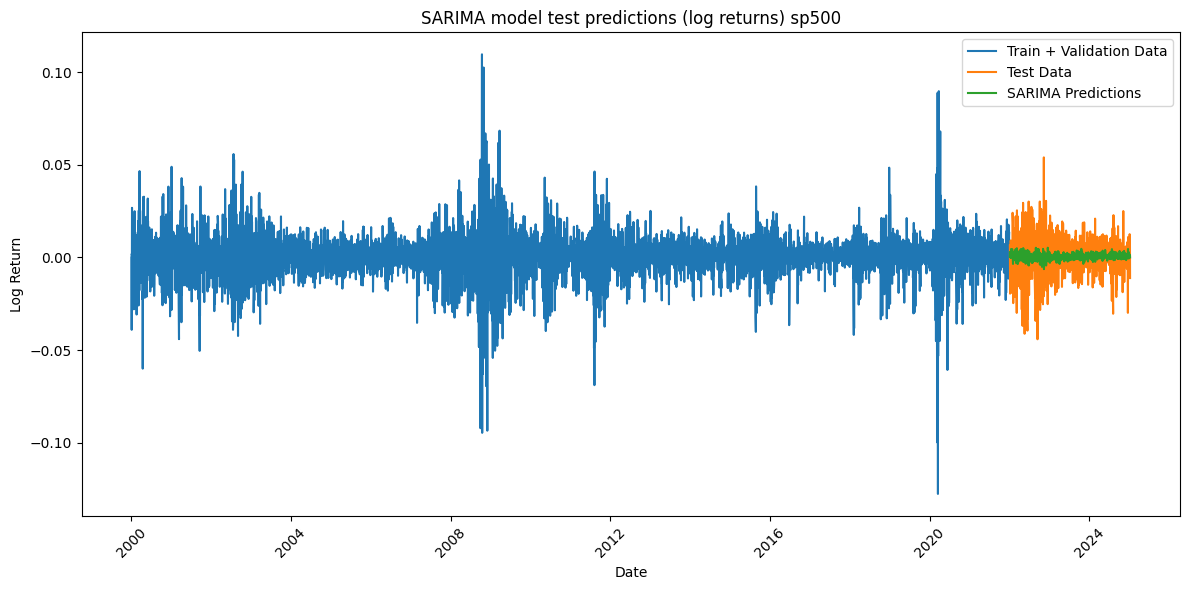

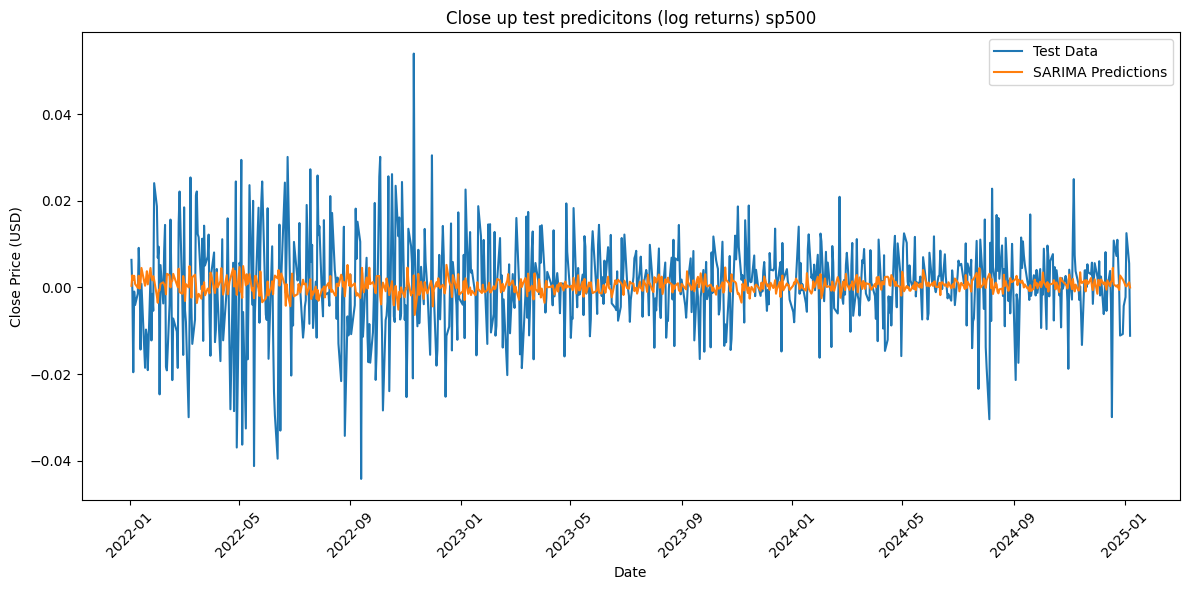

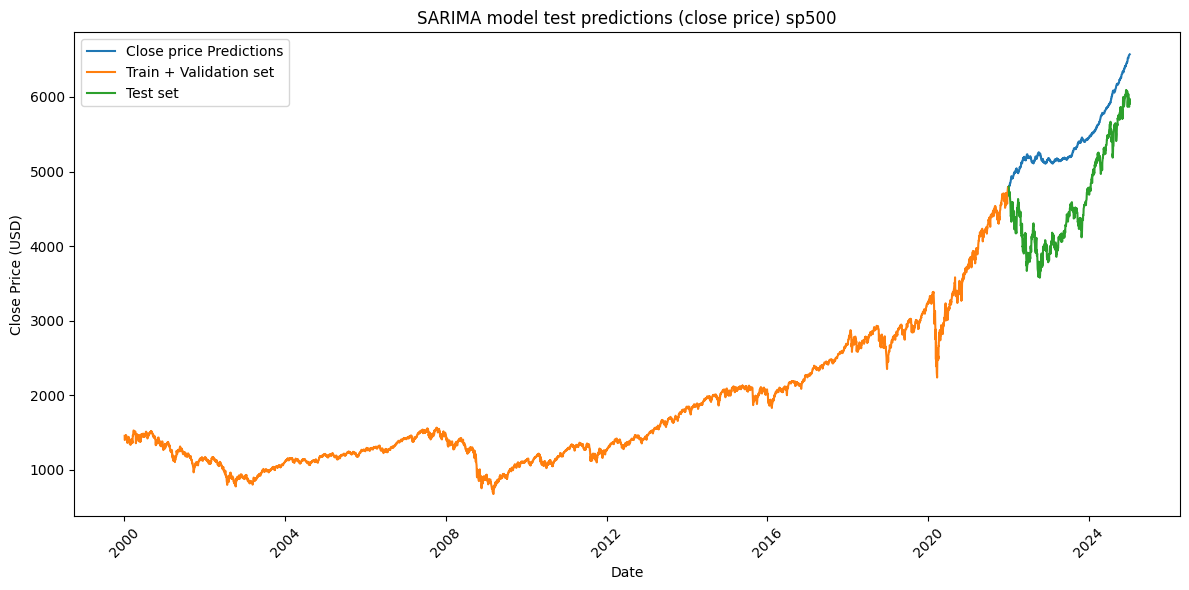

RMSE sp500: 894.6204317776196
Mean Squared Error sp500: 800345.7169539746
Mean Absolute Error sp500: 826.8709507048625
R2 Score sp500: -3.3939292781612336


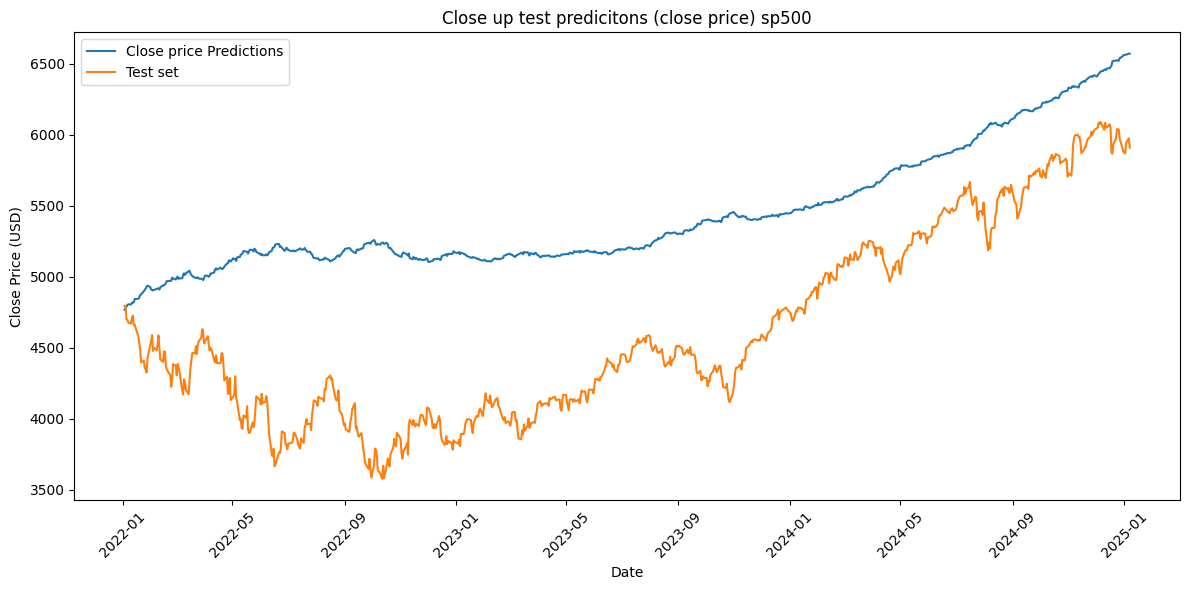

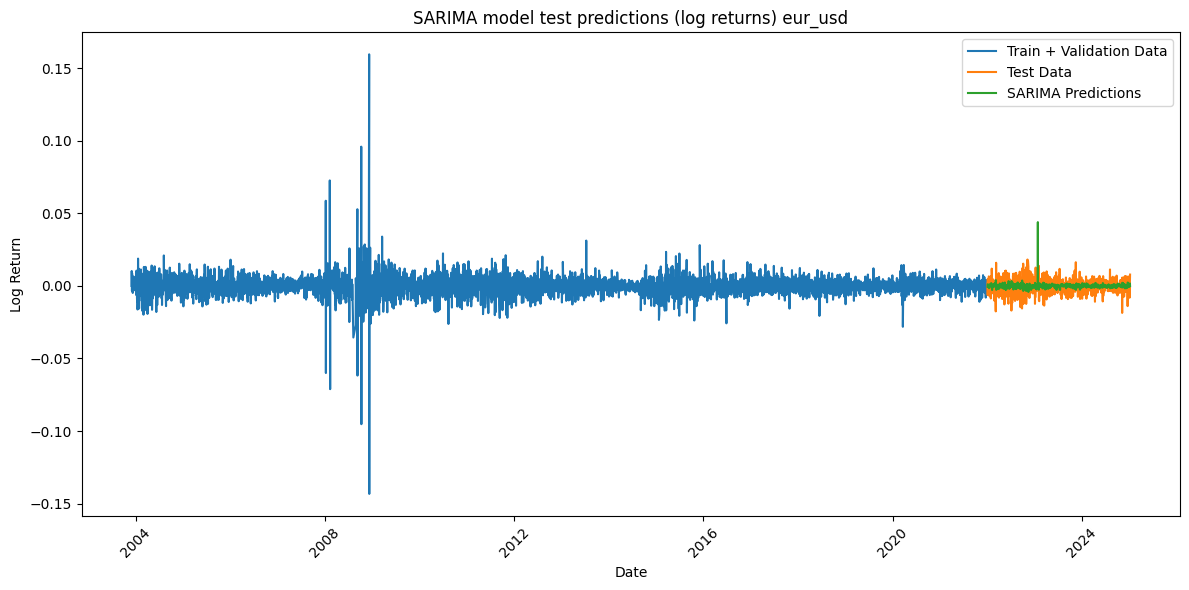

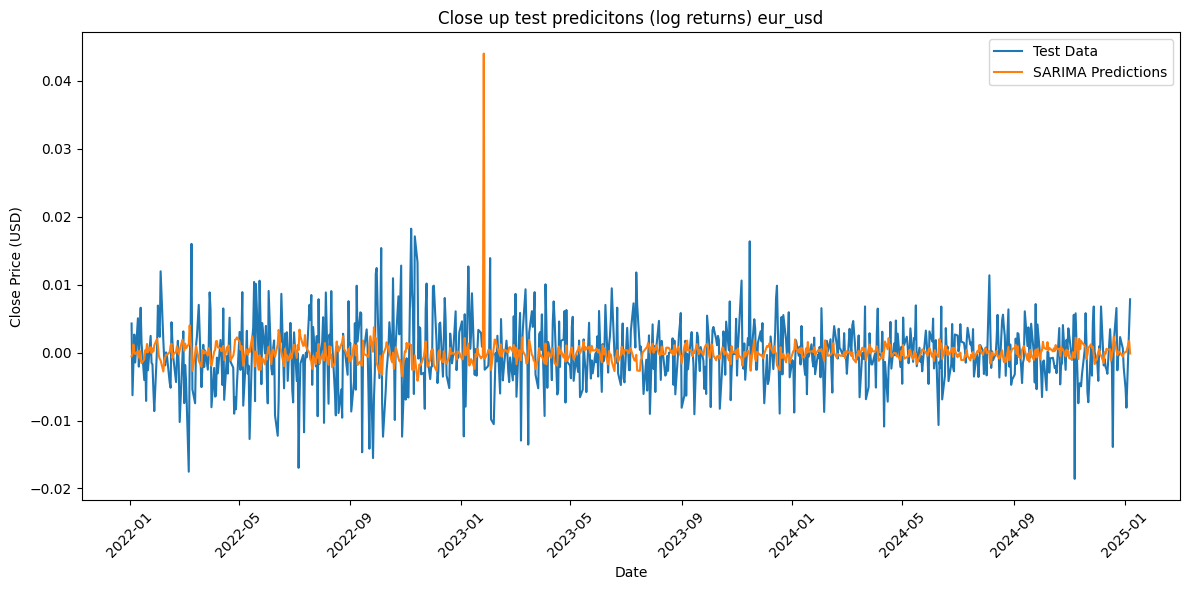

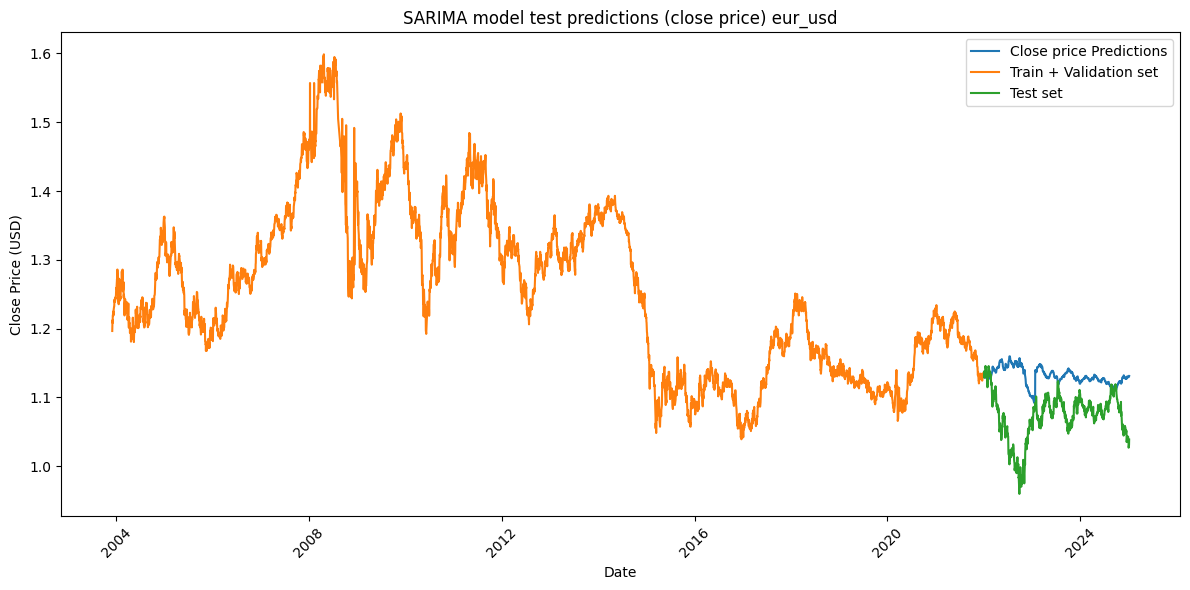

RMSE eur_usd: 0.0722620831736374
Mean Squared Error eur_usd: 0.00522180866459369
Mean Absolute Error eur_usd: 0.05942917652309806
R2 Score eur_usd: -32.93120358544012


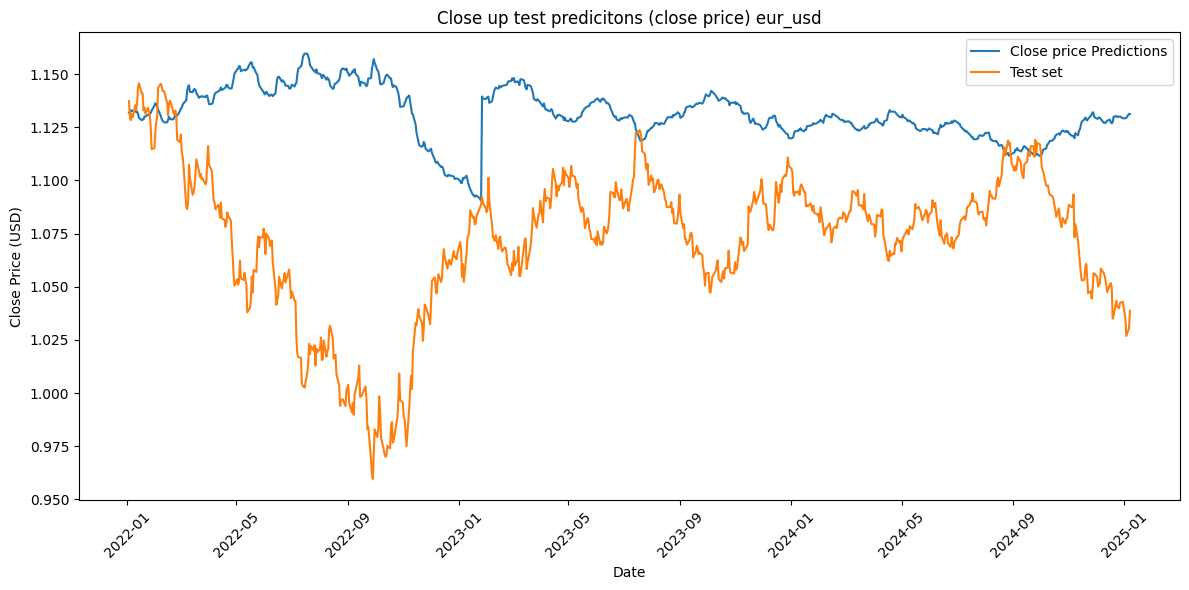

In [10]:
predicted_close_price = {}

for name, dataset in datasets.items():


    #get SARIMA test predictions
    forecast = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_log_return_predictions.csv', sep= ";")
    forecast.index = pd.to_datetime(forecast.iloc[:,0],  format = "%d/%m/%Y")
    forecast = forecast.iloc[:,1]

    #test predictions
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=train_val_data[name].index, y=train_val_data[name].values, label="Train + Validation Data")
    sns.lineplot(x=test_data[name].index, y=test_data[name].values, label="Test Data")
    sns.lineplot(x=test_data[name].index, y=forecast.values, label="SARIMA Predictions")
    plt.title(f'SARIMA model test predictions (log returns) {name}')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #close up
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_data[name].index, y=test_data[name].values, label="Test Data")
    sns.lineplot(x=test_data[name].index, y=forecast.values, label="SARIMA Predictions")
    plt.title(f'Close up test predicitons (log returns) {name}')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #price predictions
    forecast = pd.Series(forecast.values)
    forecast.index = dataset.index[len(train_val_data[name]):]
    lista = pd.concat([train_val_data[name], forecast])
    pd.set_option('display.float_format', '{:.6f}'.format)
    initial_price = dataset['Close'].iloc[0]
    predicted_close_price[name] = initial_price * np.exp(lista.cumsum())


    plt.figure(figsize=(12, 6))
    sns.lineplot(data = predicted_close_price[name][len(train_val_data[name]):], label="Close price Predictions")
    sns.lineplot(data = dataset['Close'][:len(train_val_data[name])], label="Train + Validation set")
    sns.lineplot(x=dataset[len(train_val_data[name]):].index, y=dataset['Close'][len(train_val_data[name]):].squeeze(), label="Test set")
    plt.title(f'SARIMA model test predictions (close price) {name}')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #compute metrics
    mse = mean_squared_error(predicted_close_price[name][len(train_val_data[name]):], dataset['Close'][len(train_val_data[name]):])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(predicted_close_price[name][len(train_val_data[name]):], dataset['Close'][len(train_val_data[name]):])
    r2 = r2_score(predicted_close_price[name][len(train_val_data[name]):], dataset['Close'][len(train_val_data[name]):])

    print(f'RMSE {name}: {rmse}')
    print(f'Mean Squared Error {name}: {mse}')
    print(f'Mean Absolute Error {name}: {mae}')
    print(f'R2 Score {name}: {r2}')


    #close up
    plt.figure(figsize=(12, 6))
    sns.lineplot(data = predicted_close_price[name][len(train_val_data[name]):], label="Close price Predictions")
    sns.lineplot(x=dataset[len(train_val_data[name]):].index, y=dataset['Close'][len(train_val_data[name]):].squeeze(), label="Test set")
    plt.title(f'Close up test predicitons (close price) {name}')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #save close price test predictions
    SARIMA_predictions = pd.Series(predicted_close_price[name][len(train_val_data[name]):], index = dataset.index[len(train_val_data[name]):])
    file_path = f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_predictions.csv'
    SARIMA_predictions.to_csv(file_path, index=True)

Train Val predictions

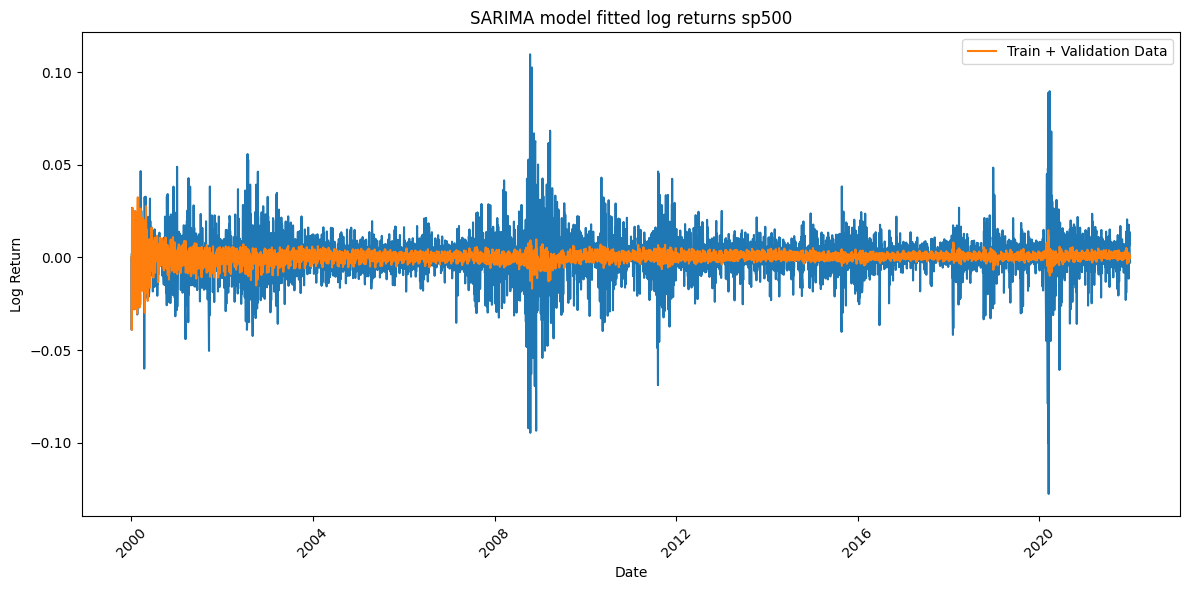

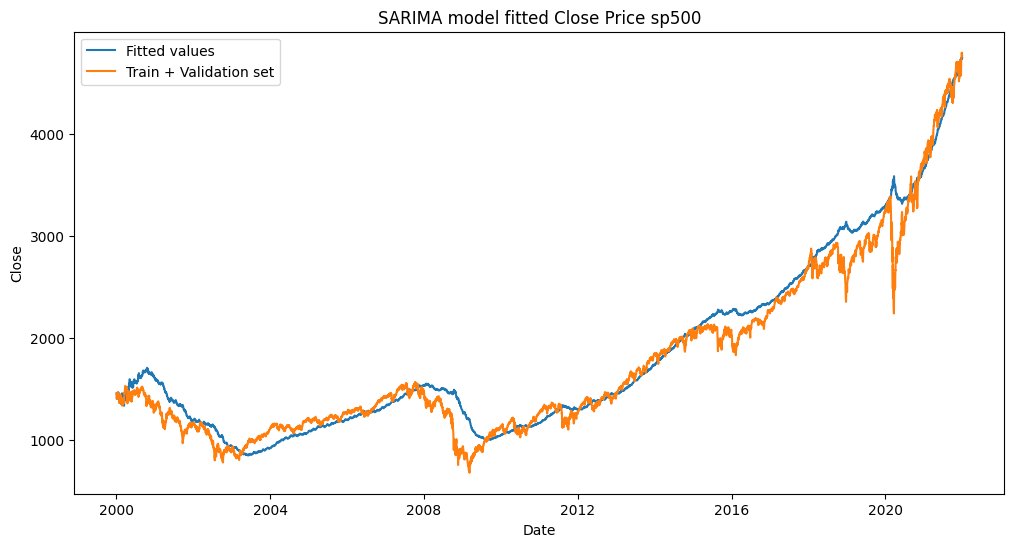

RMSE sp500: 170.3523505987556
Mean Squared Error sp500: 29019.92335452135
Mean Absolute Error sp500: 122.1423828500708
R2 Score sp500: 0.9605679581769574


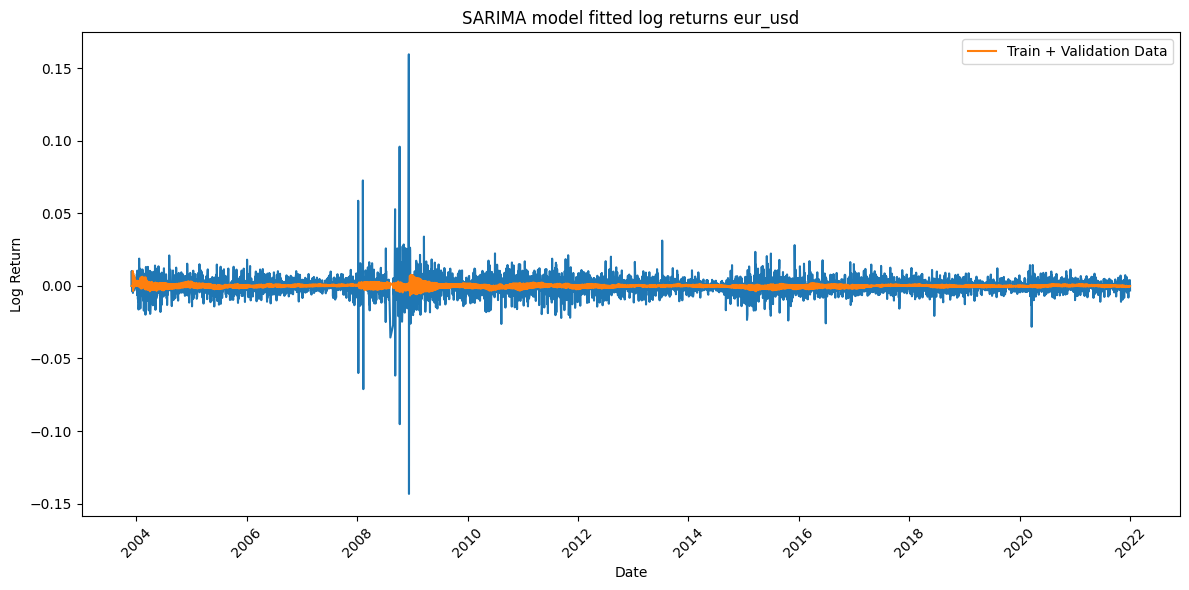

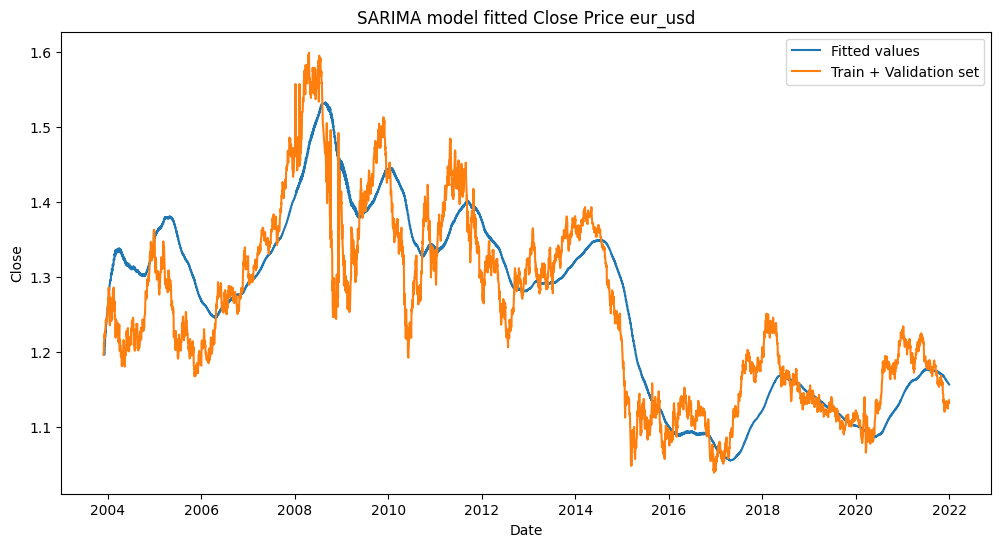

RMSE eur_usd: 0.062188296700466016
Mean Squared Error eur_usd: 0.0038673842465051927
Mean Absolute Error eur_usd: 0.047502509637668264
R2 Score eur_usd: 0.7269622952503243


In [11]:
fitted_close_price = {}

for name , dataset in datasets.items():

    #prediction on train val set
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=train_val_data[name].index, y=train_val_data[name])
    sns.lineplot(x=train_val_data[name].index, y=model[name].fittedvalues, label="Train + Validation Data")
    plt.title(f'SARIMA model fitted log returns {name}')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #fitted close price
    initial_price = dataset['Close'].iloc[0]
    fitted_close_price[name] = initial_price * np.exp(model[name].fittedvalues.cumsum())

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=fitted_close_price[name], label="Fitted values")
    sns.lineplot(x=dataset[:len(train_val_data[name])].index, y=dataset['Close'][:len(train_val_data[name])].squeeze(), label="Train + Validation set")
    plt.title(f'SARIMA model fitted Close Price {name}')
    plt.xlabel('Date')
    plt.show()


    #compute metrics
    mse = mean_squared_error(dataset['Close'][:len(train_val_data[name])], fitted_close_price[name])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(dataset['Close'][:len(train_val_data[name])], fitted_close_price[name])
    r2 = r2_score(dataset['Close'][:len(train_val_data[name])], fitted_close_price[name])

    print(f'RMSE {name}: {rmse}')
    print(f'Mean Squared Error {name}: {mse}')
    print(f'Mean Absolute Error {name}: {mae}')
    print(f'R2 Score {name}: {r2}')

    #save fitted values
    SARIMA_fitted_values = pd.Series(fitted_close_price[name], index = dataset.index[:len(train_val_data[name])])
    path = f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_fitted_values.csv'
    SARIMA_fitted_values.to_csv(path, index=True)

##Residuals

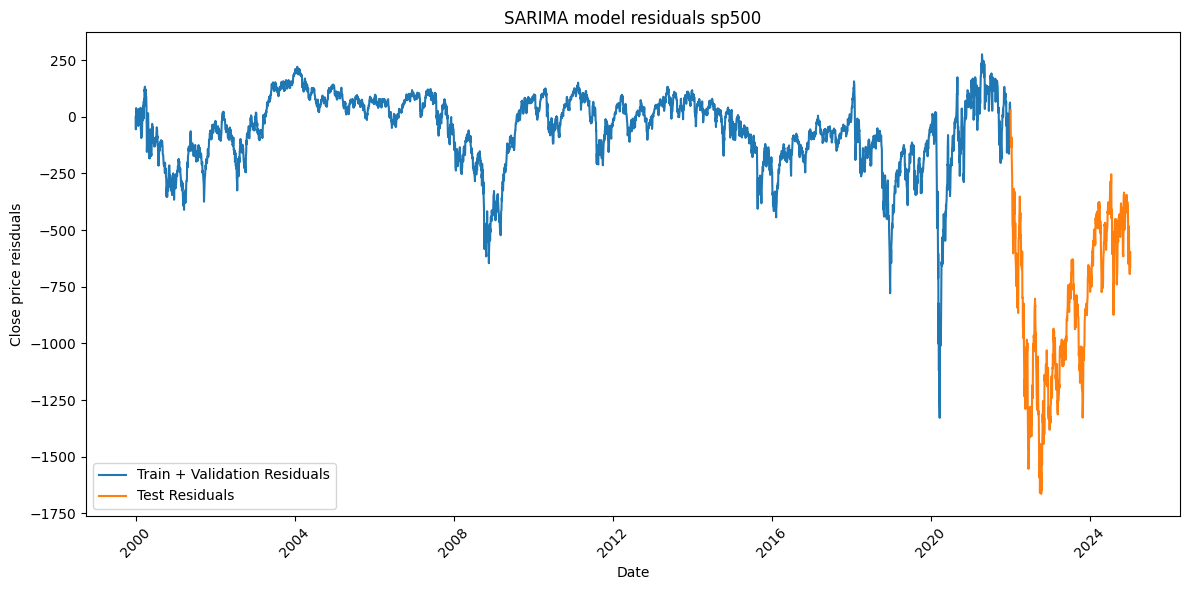

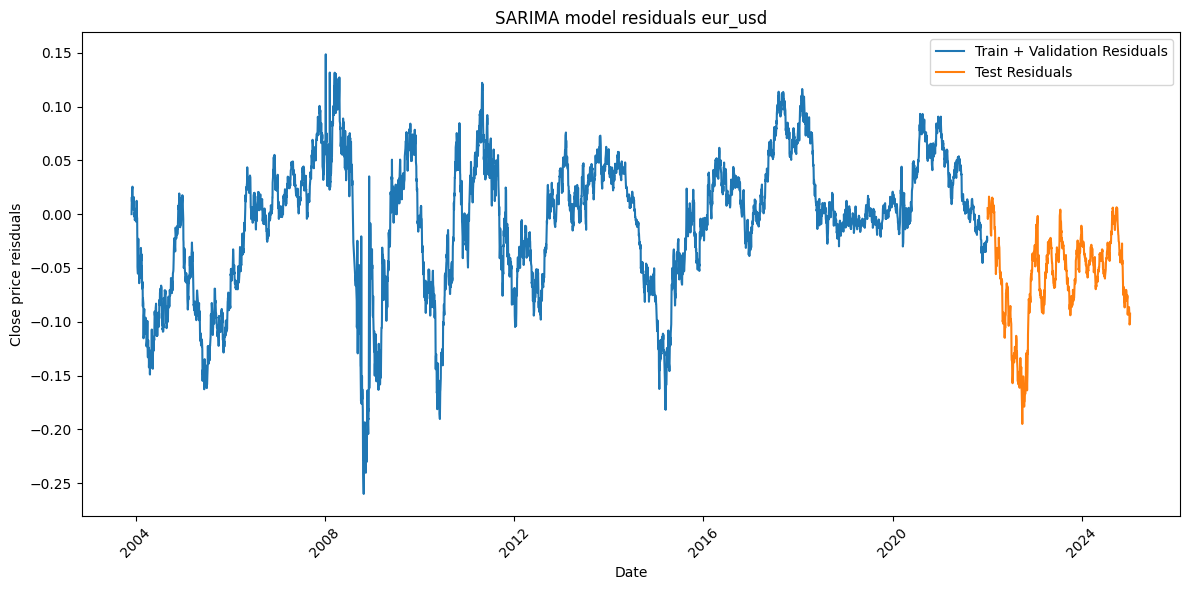

In [31]:
for name , dataset in datasets.items():


    train_val_residuals =  dataset['Close'][:len(train_val_data[name])] - fitted_close_price[name]
    test_residuals = dataset['Close'][len(train_val_data[name]):] - predicted_close_price[name][len(train_val_data[name]):]


    #visualize
    plt.figure(figsize=(12, 6))
    sns.lineplot(data = train_val_residuals, label="Train + Validation Residuals")
    sns.lineplot(data = test_residuals, label="Test Residuals")
    plt.title(f'SARIMA model residuals {name}')
    plt.xlabel('Date')
    plt.ylabel('Close price reisduals')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()


    #save residuals
    SARIMA_train_val_residuals = pd.Series(train_val_residuals, index = dataset.index[:len(train_val_data[name])])
    SARIMA_test_residuals = pd.Series(test_residuals, index = dataset.index[len(train_val_data[name]):])

    path = f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_train_val_residuals.csv'
    SARIMA_train_val_residuals.to_csv(path, index=True)

    path = f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_residuals.csv'
    SARIMA_test_residuals.to_csv(path, index=True)


    SARIMA_residuals = pd.concat([SARIMA_train_val_residuals, SARIMA_test_residuals])
    path = f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_residuals.csv'
    SARIMA_residuals.to_csv(path, index=True)


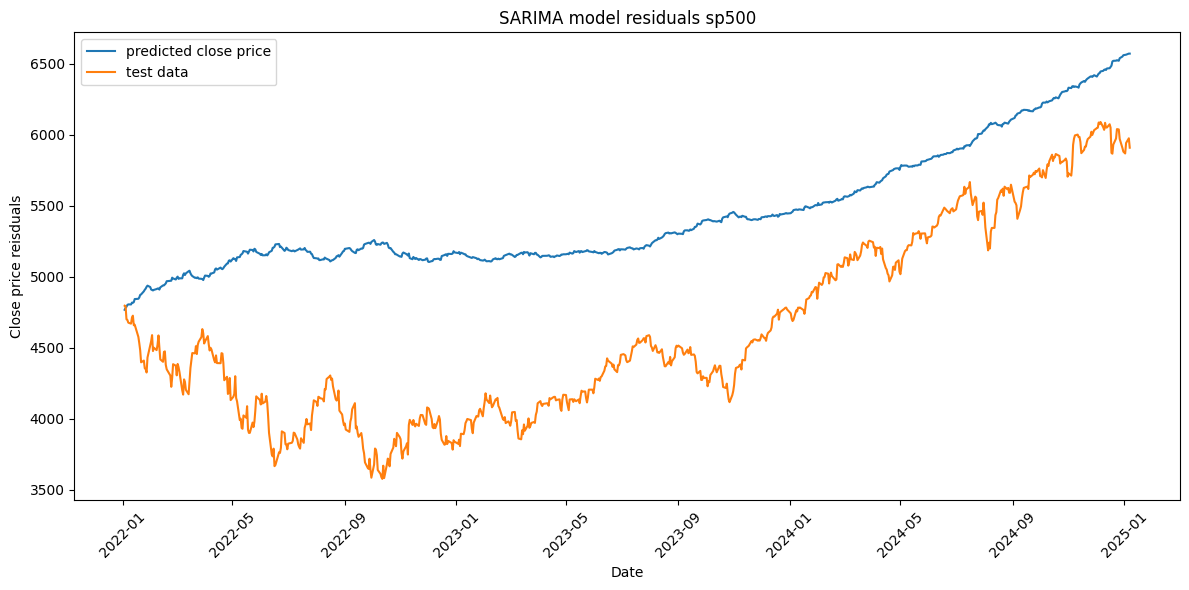

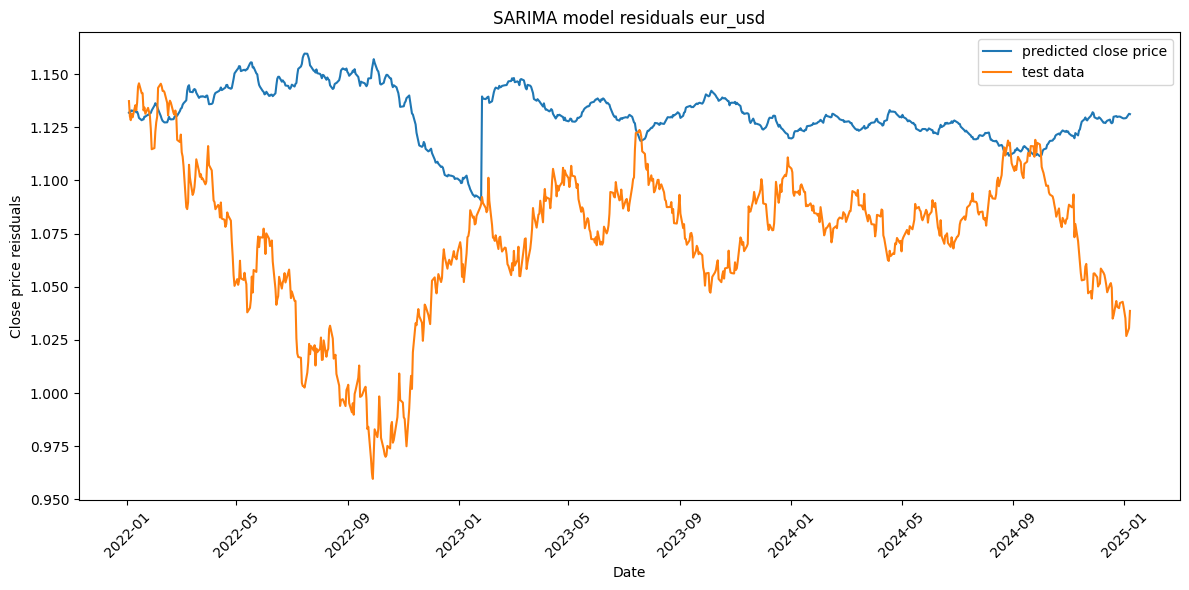

In [21]:
for name , dataset in datasets.items():


    train_val_residuals = fitted_close_price[name] - dataset['Close'][:len(train_val_data[name])]
    test_residuals = dataset['Close'][len(train_val_data[name]):] - predicted_close_price[name][len(train_val_data[name]):]


    #visualize
    plt.figure(figsize=(12, 6))
    sns.lineplot(data = predicted_close_price[name][len(train_val_data[name]):], label = "predicted close price")
    sns.lineplot(data=dataset['Close'][len(train_val_data[name]):], label = "test data")
    # sns.lineplot(data = train_val_residuals, label="Train + Validation Residuals")
    # sns.lineplot(data = test_residuals, label="Test Residuals")
    plt.title(f'SARIMA model residuals {name}')
    plt.xlabel('Date')
    plt.ylabel('Close price reisduals')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()


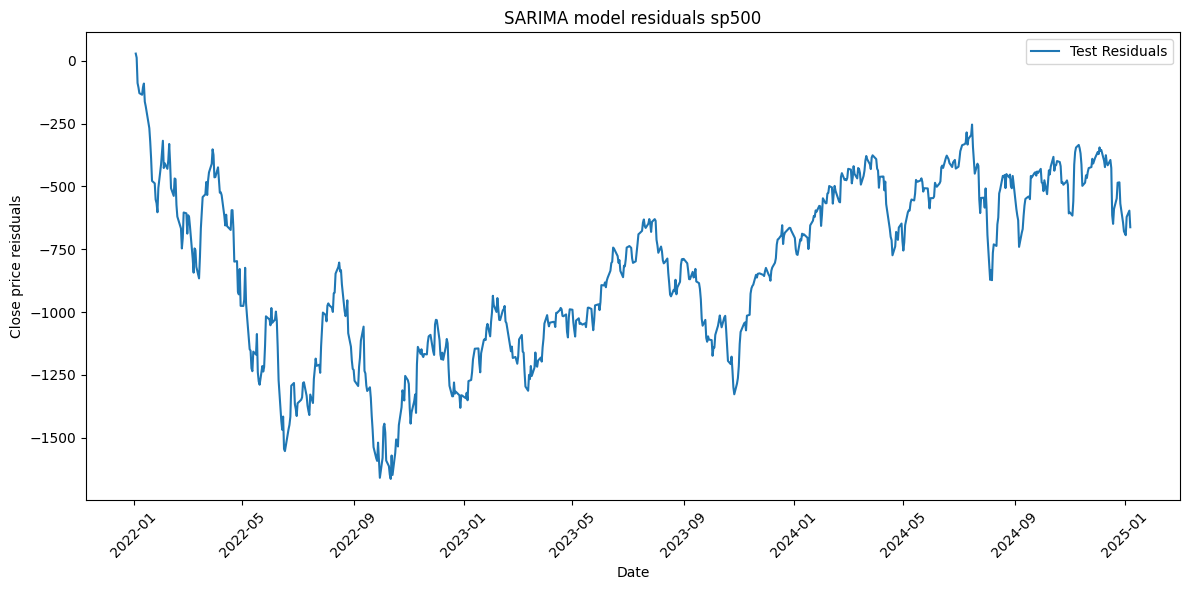

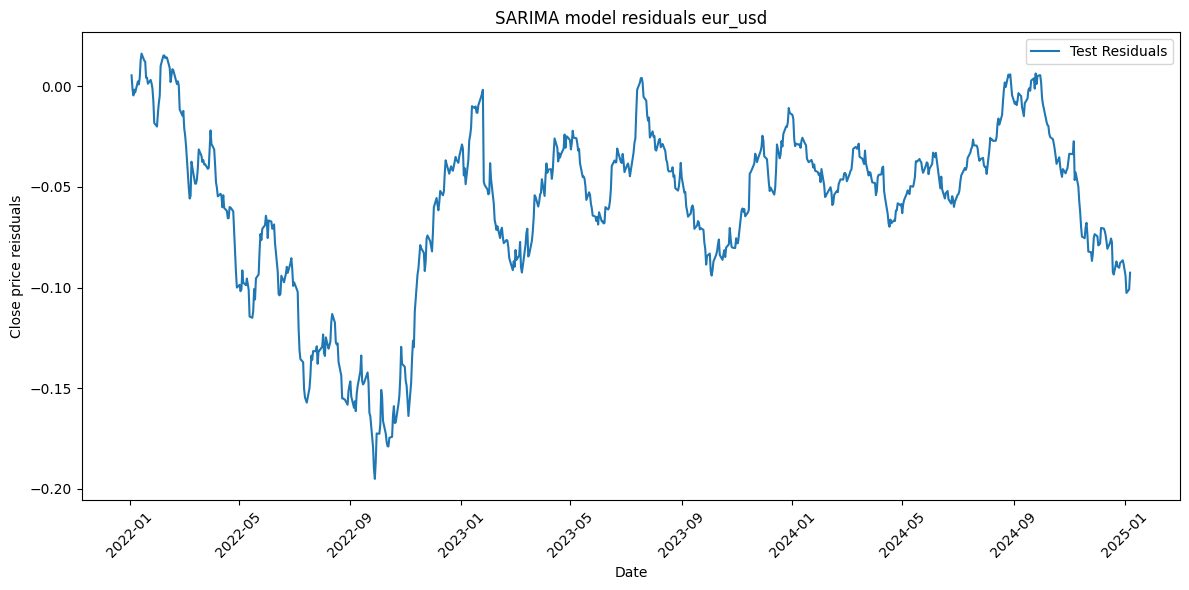

In [30]:
for name , dataset in datasets.items():


    # train_val_residuals = fitted_close_price[name] - dataset['Close'][:len(train_val_data[name])]
    # test_residuals = dataset['Close'][len(train_val_data[name]):] - predicted_close_price[name][len(train_val_data[name]):]
    test_residuals =  dataset['Close'][len(train_val_data[name]):] - predicted_close_price[name][len(train_val_data[name]):]

    #visualize
    plt.figure(figsize=(12, 6))
    # sns.lineplot(data = predicted_close_price[name][len(train_val_data[name]):], label = "predicted close price")
    # sns.lineplot(data=dataset['Close'][len(train_val_data[name]):], label = "test data")
    # sns.lineplot(data = train_val_residuals, label="Train + Validation Residuals")
    sns.lineplot(data = test_residuals, label="Test Residuals")
    plt.title(f'SARIMA model residuals {name}')
    plt.xlabel('Date')
    plt.ylabel('Close price reisduals')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
